In [1]:
import numpy as np
import pandas as pd
import synthpops as sp
from collections import Counter
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import cmasher as cmr

In [2]:
# Pretty fonts
try:
    fontstyle = 'Roboto_Condensed'
    mplt.rcParams['font.family'] = fontstyle.replace('_', ' ')
except:
    mplt.rcParams['font.family'] = 'Roboto'
mplt.rcParams['font.size'] = 16

In [3]:
homedir = os.path.expanduser('~')

# Tell us where your DHS data resides. By default, mine resides here:
dhs_datadir = os.path.join(homedir, 'Dropbox (IDM)', 'COVID-19 (1)', 'Exemplar-Practices-Africa', 'Data')

In [4]:
def get_dhs_file(file_type, year):
    folder_suffix_dic = {
        2016: '7IFL',
        2017: '7ZDT',
        2018: '80FL',
    }
    file_type_dic = {'household_linelist': 'HR', 'individual': 'IR'}
    file_dic = {2016: '7IFL', 2017: '7ZFL', 2018: '80FL'}
    file_suffix_dic = {2016: 'DAT', 2017: 'DTA', 2018: 'DAT'}
    file_path = os.path.join(dhs_datadir, 'DHS-SN{}'.format(year),
                             'SN{0}{1}'.format(file_type_dic[file_type], folder_suffix_dic[year], 'SN{0}{1}}'),
                             'SN{0}{1}.{2}'.format(file_type_dic[file_type], file_dic[year], file_suffix_dic[year]))

    return file_path

In [5]:
year = 2017
file_type = 'household_linelist'
file_path = get_dhs_file(file_type, year)

In [6]:
df = pd.read_stata(file_path)

In [7]:
df.head()

,hhid,hv000,hv001,hv002,hv003,hv004,hv005,hv006,hv007,hv008,...,sb113n_41,sb113n_42,sb113n_43,sb113n_44,sb113n_45,sb113n_46,sb113n_47,sb113n_48,sb113n_49,sb113n_50
0,1 1,SN7,1,1,1,1,2679808,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,SN7,1,2,1,1,2679808,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,SN7,1,3,2,1,2679808,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 5,SN7,1,5,1,1,2679808,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 6,SN7,1,6,1,1,2679808,10,2017,1414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
age_columns = ['hv105_0' + str(i) for i in range(1, 10)] + ['hv105_' + str(i) for i in range(10, 51)]

In [9]:
relation_columns = ['hv101_0' + str(i) for i in range(1, 10)] + ['hv101_' + str(i) for i in range(10, 51)]

In [10]:
columns = ['hhid', 'hv002', 'hv024'] + relation_columns + age_columns

In [11]:
new_df = df[columns]

In [12]:
new_df.head()

,hhid,hv002,hv024,hv101_01,hv101_02,hv101_03,hv101_04,hv101_05,hv101_06,hv101_07,...,hv105_41,hv105_42,hv105_43,hv105_44,hv105_45,hv105_46,hv105_47,hv105_48,hv105_49,hv105_50
0,1 1,1,dakar,head,wife or husband,son/daughter,son/daughter,son/daughter,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,2,dakar,head,son/daughter,son/daughter,son/daughter,son/daughter,son/daughter,son/daughter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,3,dakar,head,wife or husband,son/daughter,son/daughter,son/daughter-in-law,grandchild,son/daughter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 5,5,dakar,head,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 6,6,dakar,head,wife or husband,son/daughter,son/daughter,son/daughter,son/daughter,son/daughter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
new_df.to_csv(os.path.join(dhs_datadir, 'DHS-SN' + str(year), 'household_linelist.csv'))

In [14]:
def calculate_household_symmetric_matrix(df, age_columns, density_or_frequency='density', household_size=None):
    matrix = np.zeros((101, 101))
    
    for i, row in new_df.iterrows():
        
        ages = np.array(row[age_columns])
        ages = [a for a in ages if a != "don't know"]
        ages = [a if isinstance(a, float) else 95 if a == '95+' else a for a in ages]
        ages = [int(a) for a in ages if not np.isnan(a)]
        
        if household_size is not None:
            if len(ages) != household_size:
                continue
        
        if len(ages) > 1:
            age_counter = Counter(ages)
            for ai in age_counter:
                for aj in age_counter:
                    if density_or_frequency == 'frequency':
                        if ai != aj:
                            matrix[ai][aj] += (age_counter[aj])/(len(ages) - 1)
                        elif ai == aj:
                            matrix[ai][aj] += (age_counter[aj] - 1)/(len(ages) - 1)
                    else:
                        if ai != aj:
                            matrix[ai][aj] += age_counter[aj]
                        else:
                            matrix[ai][aj] += age_counter[aj] - 1                    
                    
    return matrix

In [15]:
def calculate_ages(df, age_columns):
    age_counter = dict.fromkeys(np.arange(101), 0)
    for i, row in df.iterrows():
        
        ages = np.array(row[age_columns])
        ages = [a for a in ages if a != "don't know"]
        ages = [a if isinstance(a, float) else 95 if a == '95+' else a for a in ages]
        ages = [int(a) for a in ages if not np.isnan(a)]
        
        for a in ages:
            age_counter[a] += 1

    return age_counter

In [16]:
def sort_households_by_size(df, age_columns):
    households_by_size = {}
    for s in range(1, 51):
        households_by_size[s] = []
    
    for i, row in df.iterrows():
        
        ages = np.array(row[age_columns])
        ages = [a for a in ages if a != "don't know"]
        ages = [a if isinstance(a, float) else 95 if a == '95+' else a for a in ages]
        ages = [int(a) for a in ages if not np.isnan(a)]
        
        s = len(ages)
        
        households_by_size[s].append(ages)
    return households_by_size

In [17]:
m = calculate_household_symmetric_matrix(new_df, age_columns, 'density')
print(m)

[[ 456.  708. 1027. ...    0.    0.    0.]
 [ 736.  416.  695. ...    0.    0.    0.]
 [1043.  713.  393. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]


In [18]:
ages = calculate_ages(new_df, age_columns)
for a in ages:
    print(a, ages[a])

0 2620
1 2452
2 2479
3 2649
4 2597
5 2381
6 2778
7 2779
8 2502
9 2142
10 2473
11 1913
12 2327
13 2139
14 1860
15 1698
16 1544
17 1819
18 1779
19 1381
20 1767
21 1039
22 1279
23 1098
24 973
25 1435
26 815
27 1051
28 993
29 802
30 1368
31 799
32 966
33 719
34 694
35 1082
36 632
37 783
38 618
39 541
40 904
41 476
42 602
43 544
44 430
45 723
46 356
47 476
48 373
49 332
50 641
51 509
52 665
53 423
54 398
55 663
56 353
57 426
58 332
59 262
60 606
61 268
62 352
63 322
64 194
65 518
66 171
67 296
68 185
69 161
70 457
71 130
72 190
73 105
74 91
75 247
76 78
77 97
78 96
79 57
80 170
81 55
82 57
83 44
84 39
85 62
86 30
87 31
88 20
89 18
90 52
91 9
92 9
93 7
94 4
95 49
96 0
97 0
98 0
99 0
100 0


In [19]:
households_by_size = sort_households_by_size(new_df, age_columns)

In [20]:
for s in households_by_size:
    print(s, len(households_by_size[s]))

1 458
2 311
3 414
4 519
5 662
6 762
7 757
8 643
9 583
10 488
11 428
12 364
13 287
14 297
15 213
16 170
17 146
18 137
19 115
20 107
21 80
22 57
23 62
24 42
25 47
26 36
27 26
28 35
29 20
30 13
31 13
32 6
33 9
34 9
35 16
36 3
37 7
38 5
39 0
40 5
41 6
42 3
43 2
44 2
45 0
46 2
47 0
48 1
49 4
50 8


In [21]:
age_brackets = {a: [a] for a in range(101)}
aggregate_age_count = {a: ages[a] for a in range(101)}
age_by_brackets_dic = sp.get_age_by_brackets_dic(age_brackets)

In [22]:
avgs = 0
for s in households_by_size:
    avgs += s * len(households_by_size[s])
avgs = avgs / np.sum([len(households_by_size[s]) for s in households_by_size])
print(avgs)

9.418973747016706


/home/dmistry/Dropbox (IDM)/dmistry_COVID-19/synthpop/synthpops/base.py:194: RuntimeWarning: invalid value encountered in true_divide
  M[a, :] = M[a, :] / float(aggregate_ages[a])
/home/dmistry/.local/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


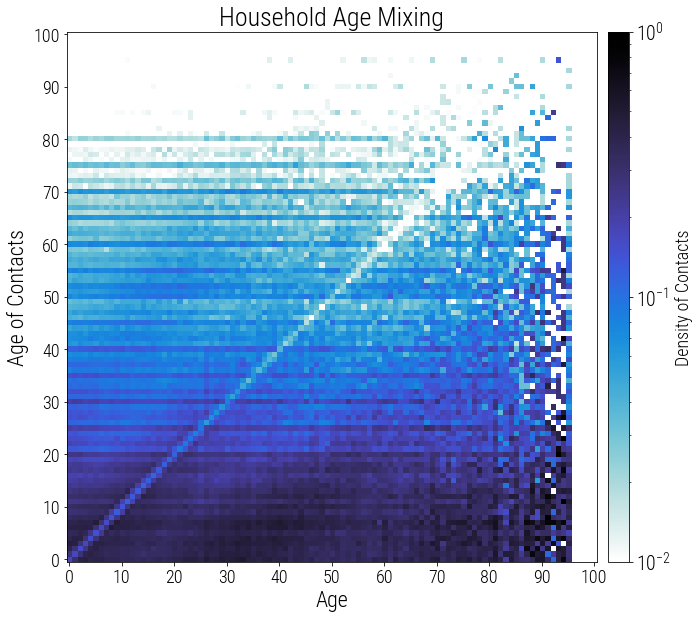

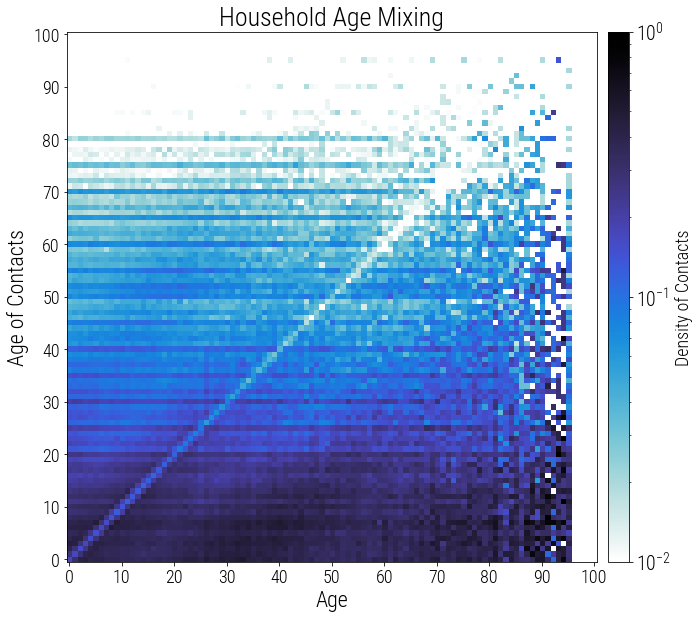

In [23]:
sp.plot_contact_matrix(m, ages, aggregate_age_count, age_brackets, age_by_brackets_dic, 'H', 'density', logcolors_flag=True, aggregate_flag=False)

/home/dmistry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


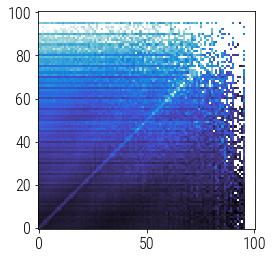

In [24]:
asym_m = m.copy()
for a in ages:
    asym_m[a, :] = asym_m[a, :] / ages[a]
plt.imshow(asym_m.T, origin='lower', interpolation = 'nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=1e-3, vmax=1e-0))

In [25]:
sizes = {}
for s in households_by_size:
    sizes[s] = len(households_by_size[s])
sizes_2 = sp.get_household_size_distr(dhs_datadir, state_location='Dakar', country_location='Senegal')

Text(0, 0.5, 'Percent (%)')

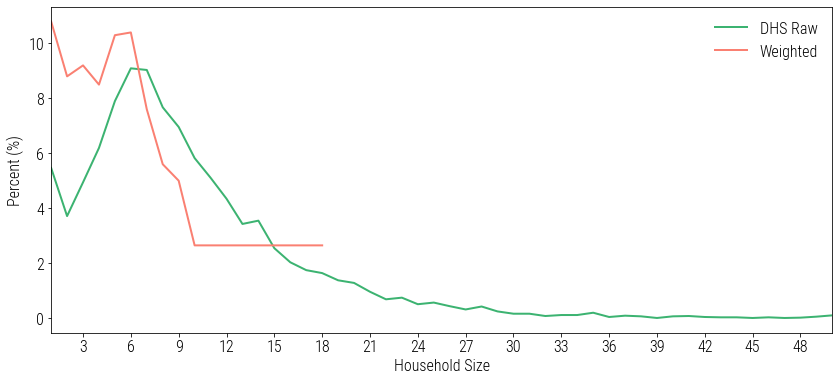

In [26]:
size_range = np.arange(1, 51)
size_range_2 = sorted(sizes_2.keys())

fig = plt.figure(figsize=(14, 6))
ax  = fig.add_subplot(111)
ax.plot(size_range, [sizes[s] * 100/sum(sizes.values()) for s in size_range], color = 'mediumseagreen', lw = 2, label='DHS Raw')
ax.plot(size_range_2, [sizes_2[s] * 100/sum(sizes_2.values()) for s in size_range_2], color = 'salmon', lw = 2, label='Weighted')
ax.set_xticks(np.arange(0, 51, 3))
ax.set_xlim(1, 50)
leg = ax.legend(loc=1)
leg.draw_frame(False)
ax.set_xlabel('Household Size')
ax.set_ylabel('Percent (%)')

Note: current supported bracket choices are 16 or 20, use 18 at your own risk.
Done: number of brackets is set to 18.
{0: 0.12, 1: 0.11699999999999999, 2: 0.105, 3: 0.098, 4: 0.096, 5: 0.1, 6: 0.083, 7: 0.065, 8: 0.051, 9: 0.039, 10: 0.037000000000000005, 11: 0.028999999999999998, 12: 0.024, 13: 0.013999999999999999, 14: 0.009000000000000001, 15: 0.005, 16: 0.003, 17: 0.002}


Text(0, 0.5, 'Age Count')

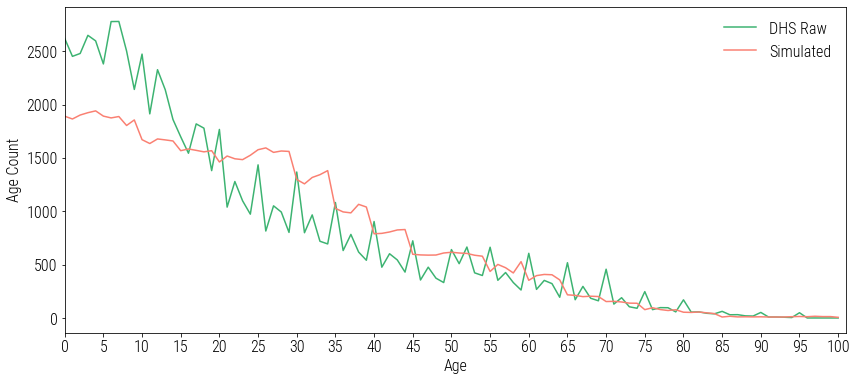

In [27]:
sp.set_nbrackets(18)
age_bracket_distr = sp.read_age_bracket_distr(dhs_datadir, state_location='Dakar', country_location='Senegal')
age_brackets = sp.get_census_age_brackets(dhs_datadir, state_location='Dakar', country_location='Senegal')
print(age_bracket_distr)
fig2 = plt.figure(figsize=(14, 6))
ax2 = fig2.add_subplot(111)
syn_age_array = sp.get_age_n(dhs_datadir,n=sum(ages.values()), state_location='Dakar', country_location='Senegal', age_brackets=age_brackets, age_bracket_distr=age_bracket_distr)
syn_ages = Counter(syn_age_array)
norm_syn_ages = sp.norm_dic(syn_ages)
ax2.plot(np.arange(101), [ages[a] for a in range(101)], color = 'mediumseagreen', label='DHS Raw')
ax2.plot(np.arange(101), [syn_ages[a] for a in range(101)], color = 'salmon', label='Simulated')
leg2 = ax2.legend(loc=1)
leg2.draw_frame(False)
ax2.set_xlim(0, 101)
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_xlabel('Age')
ax2.set_ylabel('Age Count')

In [28]:
households_by_size[10]

[[47, 43, 21, 14, 12, 9, 5, 2, 1, 69],
 [73, 33, 13, 14, 13, 35, 13, 10, 7, 3],
 [49, 42, 19, 17, 14, 12, 10, 7, 3, 1],
 [62, 15, 13, 24, 2, 0, 40, 14, 12, 9],
 [34, 25, 10, 7, 4, 0, 22, 6, 3, 1],
 [34, 25, 5, 1, 0, 62, 22, 13, 4, 16],
 [40, 18, 0, 34, 31, 29, 26, 23, 5, 60],
 [61, 43, 19, 13, 10, 8, 3, 72, 17, 15],
 [61, 52, 18, 14, 12, 10, 31, 13, 12, 2],
 [35, 10, 6, 45, 10, 7, 3, 50, 20, 1],
 [85, 20, 18, 16, 12, 21, 26, 8, 6, 2],
 [59, 54, 51, 49, 40, 12, 10, 6, 2, 2],
 [65, 35, 6, 23, 32, 42, 12, 8, 2, 20],
 [45, 29, 10, 9, 7, 5, 5, 27, 4, 1],
 [32, 26, 5, 2, 37, 2, 25, 0, 25, 25],
 [40, 30, 14, 12, 9, 5, 3, 3, 0, 67],
 [65, 62, 45, 25, 6, 4, 1, 0, 25, 1],
 [68, 54, 26, 1, 22, 17, 34, 30, 11, 34],
 [44, 12, 12, 9, 7, 2, 29, 33, 26, 20],
 [65, 35, 4, 3, 1, 69, 25, 18, 2, 39],
 [35, 29, 12, 10, 8, 6, 4, 1, 70, 75],
 [58, 44, 13, 11, 9, 7, 26, 19, 2, 0],
 [44, 41, 21, 16, 12, 10, 8, 5, 3, 1],
 [40, 22, 4, 1, 36, 21, 2, 1, 15, 53],
 [34, 31, 65, 20, 6, 11, 6, 2, 13, 17],
 [35, 27, 6,

In [29]:
m2 = calculate_household_symmetric_matrix(new_df, age_columns, 'density', 10)

nan


/home/dmistry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


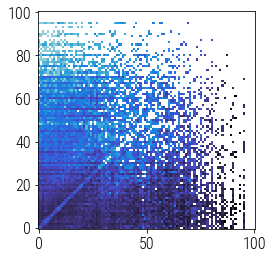

In [30]:
am2 = m2.copy()
for a in ages:
    am2[a, :] = am2[a, :]/ages[a]
print(am2.max())
plt.imshow(am2.T, origin='lower', interpolation = 'nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=1e-4, vmax=1e-1))

nan


/home/dmistry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


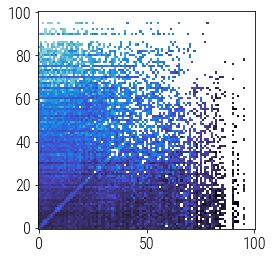

In [31]:
m3 = calculate_household_symmetric_matrix(new_df, age_columns, 'density', 11)
am3 = m3.copy()
for a in ages:
    am3[a, :] = am3[a, :]/ages[a]
print(am3.max())
plt.imshow(am3.T, origin='lower', interpolation = 'nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=1e-4, vmax=1e-1))

nan


/home/dmistry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


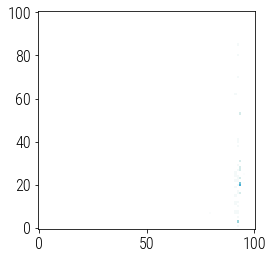

In [32]:
m4 = calculate_household_symmetric_matrix(new_df, age_columns, 'density', 12)
am4 = m4.copy()
for a in ages:
    am4[a, :] = am4[a, :]/ages[a]
print(am4.max())
plt.imshow(am4.T, origin='lower', interpolation = 'nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=1e-1, vmax=1e1))

nan


/home/dmistry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


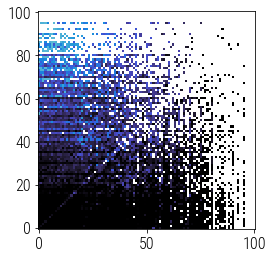

In [33]:
m5 = calculate_household_symmetric_matrix(new_df, age_columns, 'density', 13)
am5 = m5.copy()
for a in ages:
    am5[a, :] = am5[a, :]/ages[a]
print(am5.max())
plt.imshow(am5.T, origin='lower', interpolation = 'nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=1e-4, vmax=1e-2))

nan


/home/dmistry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


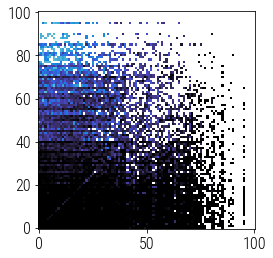

In [34]:
m6 = calculate_household_symmetric_matrix(new_df, age_columns, 'density', 14)
am6 = m6.copy()
for a in ages:
    am6[a, :] = am6[a, :]/ages[a]
print(am6.max())
plt.imshow(am6.T, origin='lower', interpolation = 'nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=1e-4, vmax=1e-2))

In [35]:
def generate_sampled_households(households_by_size, size_distr, n=500, last_size=21):
    new_size_distr = {}
    last_original_size = 10
    for s in range(1, last_original_size):
        new_size_distr[s] = size_distr[s]

    last_bracket = np.sum([size_distr[s] for s in range(last_original_size, len(size_distr) + 1)])
    last_bracket_split = last_bracket/(last_size - (last_original_size-1))
    
    for s in range(last_original_size, last_size+1):
        new_size_distr[s] = last_bracket_split
    household_sizes = sp.generate_household_sizes(n, new_size_distr)
    print(household_sizes)
    print(np.sum([s * household_sizes[s-1] for s in range(1, len(household_sizes) + 1)])/np.sum(household_sizes))
        
#     fig3 = plt.figure(figsize=(14, 6))
#     ax3  = fig3.add_subplot(111)
#     ax3.plot(np.arange(1, last_size + 1), [household_sizes[s-1] * 100/sum(household_sizes) for s in np.arange(1, last_size + 1)], color = 'mediumseagreen', lw = 2, label='DHS Raw')
#     ax3.set_xticks(np.arange(0, 51, 3))
#     ax3.set_xlim(1, 50)
#     leg = ax3.legend(loc=1)
#     leg.draw_frame(False)
#     ax3.set_xlabel('Household Size')
#     ax3.set_ylabel('Percent (%)')
    syn_households = []
    syn_households_dic = {}
    
#     senegal sizes 10 and up were randomly generated from 11 to 21
    for s in range(1, 21):
        syn_households_dic[s] = []
        print(s, household_sizes[s-1])
#         sampled_house = random.choice(households_by_size[s])
        for nh in range(household_sizes[s-1]):
            sampled_house = random.choice(households_by_size[s])
            resampled_house = [random.randint(a - 1, a + 2) if a >= 1 else random.randint(0, 2) for a in sampled_house]
            
#             print(s, nh, sampled_house, [(a-1, a+1) for a in sampled_house], resampled_house)
            print(s, nh, sampled_house, resampled_house)

            syn_households.append(resampled_house)
            syn_households_dic[s].append(resampled_house)
    
    return syn_households, syn_households_dic

In [36]:
def get_linear_y(x, x1, y1, x2, y2):
    y = (y2 - y1)/(x2 - x1) * (x - x1) + y1
    return y

In [37]:
def get_quadratic_y(x, a, b, c):
    return a * x ** 2 + b * x + c

9 0.050000000000000044
10 0.040500000000000036
11 0.03276877281399765
12 0.02642617352914406
13 0.021194591842684185
14 0.01686610931927468
15 0.013281651477088485
16 0.010317277524780344
17 0.007874888574128935
18 0.0058757649136323975
19 0.004255968288593814
20 0.002963005384407802
21 0.0019533635662771776
22 0.0011906620341952667
23 0.0006442449985208376
24 0.00028809747530500474
25 9.999999999993348e-05
0.23650057174203065


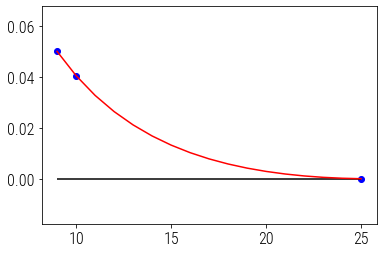

In [38]:
xseries = np.array([9, 10, 25]).reshape(-1, 1)
yseries = np.array([0.05, 0.0405, 1e-4]).reshape(-1, 1)

poly = PolynomialFeatures(degree=2)
# x_poly = poly.fit_transform(xseries)
x_poly = poly.fit_transform(np.log(xseries))

poly.fit(x_poly, yseries)
lin2 = LinearRegression()
lin2.fit(x_poly, yseries)
# lin2.predict(poly.fit_transform(xseries))
lin2.predict(poly.fit_transform(np.log(xseries)))

new_xseries = np.arange(9, 26).reshape(-1, 1)

plt.scatter(xseries, yseries, color='blue')
# plt.plot(new_xseries, lin2.predict(poly.fit_transform(new_xseries)), color='red')
plt.plot(new_xseries, lin2.predict(poly.fit_transform(np.log(new_xseries))), color='red')
plt.hlines(y=0, xmin=9, xmax=25, color='k')
# print(lin2.predict(poly.fit_transform(np.array([19.0]).reshape(-1, 1))))

sss = 0 
for s in range(9, 26):
    x = np.array(s).reshape(-1, 1)
#     x = np.log(x)
    y = lin2.predict(poly.fit_transform(np.log(x)))
    sss += y[0][0]
    print(x[0][0], y[0][0])
print(sss)

In [186]:
def extend_household_size_distr(size_distr, last_size=21, last_size_percent=1e-3, drop_factor=0.8, last_original_size=9, degree=2):
    new_size_distr = dict.fromkeys(np.arange(1, last_size+1), 0)
    for s in range(1, last_original_size + 1):
        new_size_distr[s] = size_distr[s]
    
    last_bracket = np.sum([size_distr[s] for s in range(last_original_size+1, max(size_distr.keys()) + 1)])
    previous_brackets = 1 - last_bracket
    
    x1 = last_original_size
    x2 = last_original_size + 1
    x3 = last_size
    
    y1 = new_size_distr[x1]
    y2 = new_size_distr[x1] * drop_factor
    y3 = last_size_percent

    xseries = np.array([x1, x2, x3]).reshape(-1, 1)
    yseries = np.array([y1, y2, y3]).reshape(-1, 1)
    
    poly = PolynomialFeatures(degree=degree)
    xpoly = poly.fit_transform(np.log(xseries))
    poly.fit(xpoly, yseries)
    
    lin2 = LinearRegression()
    lin2.fit(xpoly, yseries)
    
    new_xseries = np.arange(x1, x3 + 1).reshape(-1, 1)
    new_yseries = lin2.predict(poly.fit_transform(np.log(new_xseries)))
    
    fit_size_distr = {}
    for si, s in enumerate(new_xseries):
        s = s[0]
        if s > x1:
            fit_size_distr[s] = new_yseries[si]
    
    fit_size_distr = sp.norm_dic(fit_size_distr)
    for s in fit_size_distr:
        fit_size_distr[s] *= last_bracket
        
    for s in range(1, x2):
        fit_size_distr[s] = size_distr[s]
        fit_size_distr[s] *= np.sum([size_distr[s] for s in range(1, x1)]) / previous_brackets
#         fit_size_distr[s] *= previous_brackets / np.sum([size_distr[s] for s in range(1, x1)])
        
    print('last bracket', last_bracket)
    print('previous bracket', previous_brackets, np.sum([size_distr[s] for s in range(1, x2)]))
        
    print('sum of extended size distr', sum(new_yseries)[0])
    
    for si, s in enumerate(new_xseries):
        s = s[0]
        new_size_distr[s] = new_yseries[si]
    
    fit_size_distr = sp.norm_dic(fit_size_distr)
    print('average household size of fit size distr', np.sum([fit_size_distr[s] * s for s in fit_size_distr]))
    print(sum(fit_size_distr.values()))
    
    sorted_distr = {}
    for k, v in sorted(fit_size_distr.items()):
        sorted_distr[k] = v
    
    new_size_distr = sp.norm_dic(new_size_distr)
    print('average household size of new size distr', np.sum([new_size_distr[s] * s for s in new_size_distr]))
    print(sum(new_size_distr.values()))
    
    plt.scatter(list(size_distr.keys()), list(size_distr.values()), color='black')
    plt.scatter(xseries, yseries, color='blue')
    plt.plot(new_xseries, new_yseries, color = 'red')
    plt.plot([s for s in sorted(new_size_distr.keys())], [new_size_distr[s] for s in sorted(new_size_distr.keys())], color='orange', marker='o')
    plt.plot([s for s in sorted(fit_size_distr.keys())], [fit_size_distr[s] for s in sorted(fit_size_distr.keys())], color='green')
#     plt.plot([s for s in sorted_distr], [sorted_distr[s] for s in sorted_distr], color='cyan', lw=2)

#     plt.hlines(y=0, xmin=x1, xmax=x3, color = 'black')
    plt.ylim(0, 0.11)
    
    return new_size_distr

last bracket 0.23800000000000002
previous bracket 0.762 0.762
sum of extended size distr 0.4472301103761218
average household size of fit size distr 7.811048798043995
0.9999999999999998
average household size of new size distr 9.00951012095886
1.0


{1: 0.09316528188260957,
 2: 0.07591245190434855,
 3: 0.07936301790000075,
 4: 0.07332452740760939,
 5: 0.08885207438804431,
 6: 0.08971471588695737,
 7: 0.06556075391739193,
 8: 0.048307923939130894,
 9: 0.0431320749456526,
 10: 0.03795622595217423,
 11: 0.03356174557396816,
 12: 0.029788486424900066,
 13: 0.026518524357319908,
 14: 0.023662820326305834,
 15: 0.02115270736894218,
 16: 0.018934262555449395,
 17: 0.016964473100620134,
 18: 0.015208556390415302,
 19: 0.01363804402609987,
 20: 0.012229384733876494,
 21: 0.010962907622042085,
 22: 0.009822040719313066,
 23: 0.008792713605449462,
 24: 0.007862894938005611,
 25: 0.007022230267136141,
 26: 0.006261755396928381,
 27: 0.005573667343732126,
 28: 0.004951139693360594,
 29: 0.004388172532288356,
 30: 0.003879469555487001,
 31: 0.003420336722443768,
 32: 0.003006598136897855,
 33: 0.0026345257974738794,
 34: 0.0023007805976692423,
 35: 0.002002362509191639,
 36: 0.0017365683083634354,
 37: 0.0015009555342443144,
 38: 0.001293311623

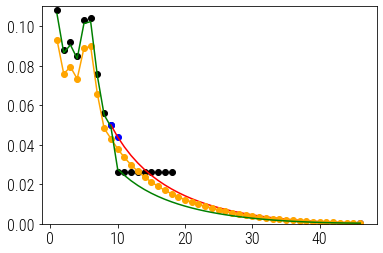

In [192]:
extend_household_size_distr(sizes_2, last_size=46, last_size_percent=5e-4, drop_factor=0.88, last_original_size=9, degree=2)

In [751]:
def generate_sampled_households_2(households_by_size, size_distr, single_year_age_distr, n=1000, last_size=21, last_size_percent=1e-3, drop_factor=0.85, last_original_size=9, degree=2):

    new_size_distr = extend_household_size_distr(size_distr, last_size, last_size_percent, drop_factor=drop_factor, last_original_size=last_original_size, degree=degree)

    household_sizes = sp.generate_household_sizes(n, new_size_distr)
    print(household_sizes)
    print(np.sum([s * household_sizes[s-1] for s in range(1, len(household_sizes) + 1)])/np.sum(household_sizes))
        
    fig3 = plt.figure(figsize=(14, 6))
    ax3  = fig3.add_subplot(111)
    ax3.plot(np.arange(1, last_size + 1), [household_sizes[s-1] * 100/sum(household_sizes) for s in np.arange(1, last_size + 1)], color = 'mediumseagreen', lw = 2, label='DHS Raw')
    
    ax3.set_xticks(np.arange(0, 51, 3))
    ax3.set_xlim(1, 50)
    leg = ax3.legend(loc=1)
    leg.draw_frame(False)
    ax3.set_ylim(bottom=0)
    ax3.set_xlabel('Household Size')
    ax3.set_ylabel('Percent (%)')
    syn_households = []
    syn_households_dic = {}
    
#   senegal sizes 10 and up were randomly generated from 11 to 21
    for s in range(1, 21):
        syn_households_dic[s] = []
        print(s, household_sizes[s-1])

        for nh in range(household_sizes[s-1]):
            sampled_house = random.choice(households_by_size[s])
            resampled_house = [random.randint(a - 1, a + 2) if a >= 1 else random.randint(0, 2) for a in sampled_house]
#             resampled_house = [random.randint(a - 1, a + 2) if a >= 1 else a for a in sampled_house]
            
            for ai, a in enumerate(resampled_house):
                if a >=2 and a <= 15:
                    if np.random.binomial(1, 0.18):
                        a = sp.sample_from_range(single_year_age_distr, 20, 50)
                        resampled_house[ai] = a
                        print(sampled_house[ai], resampled_house[ai])
                    
            
            print(s, nh, sampled_house, resampled_house)

            syn_households.append(resampled_house)
            syn_households_dic[s].append(resampled_house)
    
    return syn_households, syn_households_dic

sum of extended size distr 0.3212498631880193
average household size 7.343605559874254
1.0
[517 398 448 409 513 503 321 295 245 195 195 154 106 121  96  97  65  71
  41  33  40  24  22  19  16  19  10   5   5   7   2   2   2   2   2]
7.3672
1 517
1 0 [28] [28]
1 1 [61] [61]
1 2 [32] [34]
1 3 [72] [74]
1 4 [56] [56]
1 5 [38] [40]
1 6 [63] [62]
1 7 [35] [34]
1 8 [36] [36]
1 9 [20] [20]
1 10 [38] [39]
1 11 [74] [74]
1 12 [41] [41]
1 13 [75] [74]
1 14 [26] [25]
1 15 [40] [39]
1 16 [32] [31]
1 17 [28] [30]
1 18 [66] [68]
1 19 [31] [33]
1 20 [65] [64]
1 21 [25] [27]
1 22 [29] [30]
1 23 [72] [71]
1 24 [39] [39]
1 25 [39] [41]
1 26 [46] [48]
1 27 [31] [30]
1 28 [63] [64]
1 29 [45] [47]
1 30 [38] [38]
1 31 [56] [56]
1 32 [32] [34]
1 33 [32] [34]
1 34 [54] [56]
1 35 [61] [61]
1 36 [32] [34]
1 37 [46] [45]
1 38 [30] [30]
1 39 [56] [55]
1 40 [42] [43]
1 41 [30] [30]
1 42 [31] [31]
1 43 [67] [66]
1 44 [37] [38]
1 45 [39] [40]
1 46 [19] [19]
1 47 [23] [25]
1 48 [75] [77]
1 49 [21] [22]
1 50 [43] [44

2 104 [69, 57] [70, 56]
2 105 [23, 16] [23, 17]
2 106 [38, 30] [37, 30]
2 107 [23, 23] [25, 25]
2 108 [71, 43] [70, 45]
2 109 [78, 17] [77, 18]
2 110 [60, 24] [60, 25]
2 111 [35, 2] [35, 1]
2 112 [23, 28] [22, 28]
2 113 [67, 71] [67, 71]
2 114 [70, 20] [72, 20]
2 115 [22, 1] [21, 0]
2 116 [21, 26] [21, 27]
2 117 [46, 36] [48, 36]
2 118 [35, 21] [36, 21]
2 119 [33, 20] [32, 19]
2 120 [48, 12] [48, 11]
2 121 [30, 2] [30, 4]
2 122 [32, 26] [32, 27]
2 123 [75, 52] [75, 54]
2 124 [71, 60] [73, 59]
2 125 [50, 19] [50, 18]
2 126 [53, 17] [53, 18]
2 127 [51, 65] [53, 66]
2 128 [19, 0] [19, 2]
2 129 [21, 2] [21, 2]
8 22
2 130 [42, 8] [42, 22]
2 131 [36, 13] [37, 14]
2 132 [60, 55] [62, 54]
2 133 [65, 75] [64, 75]
2 134 [60, 55] [61, 54]
2 135 [23, 30] [23, 30]
2 136 [29, 7] [30, 6]
9 27
2 137 [54, 9] [54, 27]
2 138 [31, 40] [31, 42]
2 139 [39, 28] [38, 29]
2 140 [60, 24] [62, 25]
2 141 [75, 65] [76, 64]
2 142 [35, 30] [37, 32]
2 143 [48, 12] [50, 13]
2 144 [65, 61] [66, 61]
2 145 [72, 29] [72, 

3 378 [57, 25, 43] [57, 25, 45]
3 379 [55, 17, 14] [55, 16, 13]
3 380 [29, 24, 4] [30, 26, 4]
3 381 [52, 40, 4] [53, 39, 6]
3 382 [83, 25, 2] [83, 25, 3]
3 26
3 383 [53, 45, 3] [54, 47, 26]
3 384 [52, 35, 0] [51, 34, 1]
3 385 [60, 24, 3] [62, 26, 3]
3 386 [56, 17, 12] [56, 17, 14]
3 387 [32, 25, 24] [31, 25, 23]
4 36
3 388 [52, 40, 4] [53, 40, 36]
3 389 [31, 19, 1] [31, 21, 2]
3 390 [58, 32, 27] [59, 34, 26]
3 391 [43, 33, 2] [42, 33, 1]
4 21
3 392 [39, 22, 4] [40, 24, 21]
3 393 [73, 50, 14] [72, 51, 14]
6 45
3 394 [29, 27, 6] [30, 27, 45]
3 395 [33, 4, 2] [34, 6, 1]
3 396 [45, 7, 5] [47, 6, 6]
3 397 [61, 32, 10] [61, 33, 10]
3 398 [27, 26, 21] [27, 28, 22]
3 399 [43, 23, 6] [43, 25, 8]
3 400 [37, 29, 1] [36, 29, 2]
1 40
3 401 [43, 27, 1] [43, 26, 40]
3 402 [58, 54, 18] [58, 54, 18]
3 403 [40, 27, 37] [40, 26, 38]
3 404 [57, 54, 20] [57, 53, 19]
3 405 [69, 35, 33] [68, 34, 34]
3 406 [52, 22, 19] [53, 24, 21]
3 407 [73, 50, 14] [72, 52, 16]
3 408 [68, 14, 26] [67, 14, 28]
3 409 [44, 13,

6 48
1 28
5 189 [40, 34, 8, 6, 1] [39, 35, 8, 48, 28]
11 22
5 190 [47, 30, 11, 5, 2] [47, 29, 22, 7, 1]
5 191 [36, 31, 12, 7, 3] [36, 33, 12, 8, 5]
6 36
5 192 [49, 6, 33, 6, 48] [51, 5, 35, 36, 48]
5 193 [40, 19, 17, 4, 0] [40, 21, 16, 3, 0]
2 27
5 194 [56, 25, 7, 20, 2] [57, 25, 9, 20, 27]
5 195 [33, 30, 34, 32, 27] [32, 30, 34, 33, 26]
5 196 [54, 23, 18, 14, 12] [54, 24, 19, 16, 12]
4 28
5 197 [40, 29, 6, 4, 1] [39, 28, 6, 28, 0]
5 198 [48, 16, 8, 25, 22] [48, 15, 9, 25, 24]
5 199 [46, 27, 4, 0, 71] [46, 27, 5, 1, 70]
0 36
5 200 [63, 16, 0, 7, 5] [63, 17, 36, 6, 4]
5 201 [73, 65, 12, 10, 8] [73, 65, 12, 9, 7]
5 202 [56, 43, 15, 7, 5] [55, 43, 14, 7, 6]
5 203 [42, 23, 12, 8, 4] [42, 25, 14, 9, 3]
5 204 [37, 50, 18, 12, 2] [37, 49, 19, 14, 2]
5 205 [53, 25, 23, 20, 10] [53, 27, 25, 20, 12]
5 206 [50, 17, 42, 4, 2] [50, 16, 43, 5, 1]
3 22
5 207 [32, 25, 6, 3, 0] [34, 27, 8, 22, 2]
10 41
5 208 [73, 65, 12, 10, 8] [74, 64, 14, 41, 8]
5 209 [52, 29, 22, 2, 19] [53, 30, 22, 3, 18]
14 45
5 2

7 43
6 270 [37, 30, 9, 7, 5, 0] [38, 32, 10, 43, 6, 1]
7 41
6 271 [58, 52, 18, 10, 7, 24] [60, 54, 18, 12, 41, 26]
6 272 [42, 20, 17, 13, 9, 5] [44, 20, 18, 13, 8, 5]
6 273 [54, 27, 8, 5, 3, 1] [53, 29, 8, 5, 2, 3]
6 274 [56, 52, 15, 11, 8, 29] [55, 51, 15, 12, 7, 29]
9 35
5 37
6 275 [44, 18, 15, 12, 9, 5] [46, 17, 14, 14, 35, 37]
8 22
6 276 [30, 28, 10, 8, 3, 0] [29, 28, 9, 22, 3, 1]
14 28
6 277 [24, 1, 14, 72, 22, 20] [24, 1, 28, 74, 24, 20]
6 278 [49, 55, 27, 0, 15, 10] [49, 55, 29, 2, 16, 11]
8 46
7 20
6 279 [41, 28, 8, 7, 4, 1] [41, 27, 46, 20, 6, 1]
6 280 [45, 16, 11, 11, 5, 25] [47, 17, 12, 11, 4, 25]
6 281 [59, 55, 33, 28, 17, 20] [60, 55, 33, 30, 17, 20]
6 30
6 282 [57, 6, 4, 6, 4, 29] [56, 30, 6, 8, 3, 31]
4 20
6 283 [46, 40, 10, 7, 4, 0] [48, 40, 11, 9, 20, 0]
6 284 [64, 32, 23, 38, 23, 4] [63, 33, 25, 39, 25, 3]
6 285 [69, 11, 11, 7, 37, 0] [71, 12, 12, 6, 38, 0]
6 286 [55, 27, 19, 18, 12, 23] [54, 29, 20, 20, 11, 25]
6 287 [35, 3, 20, 53, 26, 7] [37, 4, 22, 55, 26, 7]
6 28

9 38
7 314 [39, 46, 12, 9, 5, 16, 25] [38, 47, 14, 38, 7, 16, 24]
7 21
7 315 [62, 50, 24, 20, 17, 14, 7] [63, 49, 23, 21, 18, 15, 21]
7 316 [39, 27, 4, 2, 0, 8, 6] [38, 27, 4, 1, 2, 8, 8]
13 46
6 34
7 317 [40, 33, 13, 7, 6, 3, 2] [40, 33, 46, 7, 34, 4, 3]
7 318 [80, 41, 35, 18, 20, 20, 17] [82, 43, 36, 18, 19, 22, 18]
9 23
3 38
7 319 [45, 32, 17, 12, 9, 6, 3] [47, 31, 16, 14, 23, 6, 38]
7 26
2 27
7 320 [35, 27, 12, 7, 5, 2, 23] [35, 28, 14, 26, 5, 27, 24]
8 295
8 29
8 0 [64, 45, 10, 8, 3, 0, 25, 0] [66, 44, 12, 29, 2, 2, 24, 1]
8 1 [71, 26, 17, 52, 6, 3, 24, 0] [72, 27, 19, 53, 6, 4, 25, 1]
8 2 [55, 21, 19, 17, 15, 25, 5, 0] [57, 23, 18, 16, 16, 27, 5, 1]
8 3 [70, 37, 14, 11, 2, 35, 5, 1] [71, 36, 14, 11, 3, 34, 7, 0]
5 44
8 4 [42, 19, 16, 13, 5, 25, 1, 15] [41, 18, 18, 13, 44, 27, 0, 17]
9 46
5 30
8 5 [56, 38, 14, 11, 9, 5, 5, 0] [57, 38, 15, 10, 46, 6, 30, 1]
5 23
4 25
8 6 [37, 70, 52, 10, 5, 2, 12, 4] [39, 70, 54, 11, 23, 1, 13, 25]
6 28
8 7 [53, 48, 19, 15, 12, 6, 83, 80] [54, 49, 

9 50
6 23
7 21
9 176 [50, 40, 11, 9, 6, 2, 24, 30, 7] [50, 40, 13, 50, 23, 3, 23, 31, 21]
7 34
9 177 [34, 28, 13, 11, 7, 4, 52, 72, 7] [36, 30, 13, 13, 7, 3, 52, 71, 34]
12 34
9 178 [55, 47, 21, 10, 12, 14, 8, 27, 5] [56, 47, 20, 10, 34, 15, 10, 26, 5]
6 25
3 33
9 179 [30, 12, 10, 6, 3, 53, 67, 10, 12] [31, 13, 10, 25, 33, 52, 66, 11, 13]
9 180 [63, 59, 37, 35, 26, 9, 6, 4, 1] [62, 60, 36, 36, 26, 8, 8, 6, 1]
9 181 [64, 56, 23, 20, 19, 10, 52, 11, 8] [63, 55, 24, 22, 20, 12, 54, 12, 10]
8 43
9 182 [47, 37, 17, 15, 12, 10, 8, 4, 0] [46, 39, 19, 17, 13, 12, 43, 6, 1]
9 183 [74, 48, 46, 10, 22, 3, 0, 44, 27] [74, 47, 45, 11, 22, 5, 1, 43, 26]
9 184 [61, 26, 1, 17, 12, 20, 1, 1, 18] [62, 25, 1, 16, 12, 21, 2, 0, 18]
10 22
11 36
9 185 [59, 33, 15, 13, 10, 4, 26, 6, 11] [61, 34, 15, 14, 22, 6, 25, 6, 36]
9 186 [73, 39, 21, 27, 4, 28, 7, 14, 2] [75, 40, 21, 28, 5, 28, 6, 15, 1]
7 38
14 21
11 25
9 187 [59, 50, 24, 7, 3, 16, 14, 11, 11] [60, 50, 26, 38, 2, 15, 21, 13, 25]
9 188 [57, 50, 24, 17,

3 22
11 155 [48, 19, 17, 39, 3, 35, 10, 8, 6, 3, 1] [48, 19, 19, 40, 5, 36, 9, 10, 7, 22, 1]
11 156 [52, 26, 8, 2, 18, 15, 13, 9, 10, 36, 10] [52, 26, 9, 4, 17, 17, 13, 9, 12, 37, 12]
11 157 [72, 64, 30, 55, 12, 1, 38, 9, 6, 3, 0] [74, 63, 31, 57, 14, 1, 40, 9, 8, 5, 1]
11 158 [48, 38, 15, 12, 8, 6, 0, 20, 18, 0, 80] [47, 38, 17, 11, 7, 6, 0, 21, 20, 0, 82]
4 35
11 159 [44, 15, 8, 29, 4, 70, 37, 24, 8, 5, 2] [46, 17, 8, 30, 35, 70, 37, 24, 7, 4, 4]
2 28
11 160 [61, 47, 33, 14, 11, 9, 6, 5, 2, 55, 47] [63, 48, 34, 14, 13, 10, 7, 7, 28, 55, 48]
8 21
11 161 [48, 42, 13, 8, 7, 5, 2, 0, 26, 18, 1] [47, 43, 13, 21, 8, 7, 1, 2, 27, 20, 3]
9 38
11 162 [46, 33, 7, 5, 3, 0, 81, 29, 9, 23, 59] [47, 34, 6, 7, 4, 2, 82, 31, 38, 25, 59]
11 163 [41, 40, 13, 10, 8, 6, 2, 0, 70, 63, 21] [41, 42, 15, 11, 7, 8, 4, 2, 69, 64, 23]
11 164 [47, 40, 22, 18, 12, 11, 8, 3, 91, 55, 5] [47, 40, 22, 18, 12, 11, 10, 2, 90, 54, 5]
0 37
11 165 [62, 56, 30, 27, 34, 21, 1, 90, 31, 0, 26] [64, 55, 31, 29, 34, 20, 3, 91,

14 91 [32, 30, 12, 7, 3, 47, 28, 5, 3, 1, 18, 55, 57, 19] [32, 31, 14, 6, 5, 46, 29, 7, 4, 2, 18, 54, 58, 18]
14 92 [65, 25, 20, 0, 70, 23, 68, 40, 9, 4, 50, 19, 62, 14] [67, 27, 21, 2, 70, 24, 70, 39, 8, 5, 51, 19, 61, 15]
14 93 [70, 58, 31, 12, 22, 13, 47, 14, 9, 6, 3, 30, 35, 20] [71, 60, 32, 13, 23, 13, 47, 14, 9, 7, 4, 29, 35, 21]
7 26
14 94 [56, 18, 16, 26, 28, 6, 3, 0, 25, 6, 1, 7, 4, 0] [56, 19, 16, 27, 30, 6, 4, 0, 24, 8, 0, 26, 3, 2]
10 39
8 24
14 95 [72, 47, 25, 24, 21, 18, 15, 34, 15, 10, 8, 5, 3, 1] [73, 46, 27, 24, 20, 18, 16, 35, 14, 39, 24, 7, 3, 3]
14 96 [80, 30, 8, 4, 0, 28, 31, 13, 7, 40, 23, 16, 13, 35] [79, 30, 7, 3, 1, 27, 33, 12, 7, 42, 25, 17, 14, 36]
9 27
14 97 [40, 31, 14, 11, 8, 74, 37, 31, 5, 1, 34, 28, 0, 9] [39, 30, 14, 13, 8, 73, 37, 32, 4, 0, 35, 29, 0, 27]
14 98 [45, 31, 12, 6, 6, 3, 18, 9, 32, 1, 65, 45, 25, 27] [45, 32, 11, 6, 7, 2, 17, 10, 32, 3, 65, 45, 24, 29]
6 37
14 99 [56, 18, 16, 26, 28, 6, 3, 0, 25, 6, 1, 7, 4, 0] [56, 17, 17, 27, 30, 37, 5, 0

5 46
7 20
19 11 [66, 31, 25, 2, 1, 30, 30, 6, 4, 1, 18, 15, 13, 12, 8, 6, 5, 7, 6] [68, 33, 26, 25, 2, 31, 32, 36, 5, 0, 17, 15, 13, 14, 8, 23, 46, 20, 6]
19 12 [67, 44, 17, 14, 4, 10, 47, 22, 18, 14, 50, 20, 18, 12, 45, 18, 12, 8, 76] [68, 46, 17, 16, 5, 12, 46, 24, 20, 15, 49, 22, 20, 14, 45, 17, 14, 8, 76]
19 13 [62, 51, 35, 19, 13, 54, 31, 10, 8, 5, 3, 0, 47, 16, 14, 9, 6, 18, 13] [62, 50, 37, 19, 14, 56, 31, 12, 8, 4, 4, 0, 49, 15, 13, 9, 8, 19, 13]
3 44
19 14 [35, 29, 11, 7, 5, 2, 74, 22, 0, 17, 8, 5, 3, 24, 3, 0, 20, 1, 67] [34, 30, 13, 8, 6, 3, 76, 22, 1, 18, 9, 7, 3, 23, 44, 0, 20, 0, 69]
6 33
4 23
5 23
19 15 [45, 29, 9, 6, 5, 2, 0, 26, 4, 1, 0, 22, 5, 3, 0, 8, 15, 13, 20] [44, 30, 11, 33, 7, 2, 1, 28, 23, 2, 1, 21, 23, 4, 1, 7, 17, 12, 20]
7 20
6 29
4 50
12 20
19 16 [48, 25, 10, 8, 7, 5, 3, 20, 8, 6, 4, 2, 20, 3, 0, 70, 6, 4, 12] [48, 25, 12, 10, 20, 4, 3, 22, 8, 5, 5, 3, 21, 4, 1, 71, 29, 50, 20]
19 17 [36, 35, 11, 9, 7, 3, 1, 26, 30, 32, 13, 10, 8, 2, 6, 26, 1, 65, 62] [37,

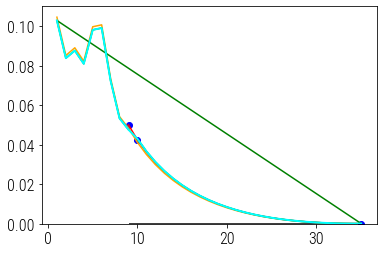

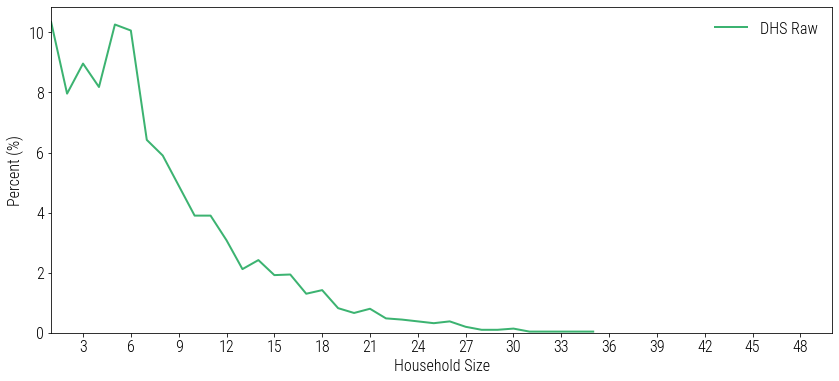

In [752]:
new_syn_households, new_syn_households_dic = generate_sampled_households_2(households_by_size, sizes_2, norm_syn_ages, n=5000, last_size=35, last_size_percent=1e-4, drop_factor=0.85, last_original_size=9, degree=2)

In [580]:
def calculate_synthetic_household_symmetric_matrix(syn_households, density_or_frequency='density', household_size=None):
    matrix = np.zeros((101, 101))

    for i, ages in enumerate(syn_households):

        if household_size is not None:
            if len(ages) != household_size:
                continue
        
        age_counter = Counter(ages)
        if len(ages) > 1:
            for ai in age_counter:
                for aj in age_counter:
                    if density_or_frequency == 'frequency':
                        if ai != aj:
                            matrix[ai][aj] += (age_counter[aj])/(len(ages) - 1)
                        elif ai == aj:
                            matrix[ai][aj] += (age_counter[aj] - 1)/(len(ages) - 1)
                    else:
                        if ai != aj:
                            matrix[ai][aj] += age_counter[aj]
                        else:
                            matrix[ai][aj] += age_counter[aj] - 1                    

    return matrix

In [342]:
def calculate_synthetic_ages(syn_households):
    age_counter = dict.fromkeys(np.arange(101), 0)

    for i, ages in enumerate(syn_households):
              
        for a in ages:
            age_counter[a] += 1

    return age_counter

In [714]:
syn_households, syn_households_dic = generate_sampled_households(households_by_size, sizes_2, 50000, 35)

[5282 4462 4451 4311 5087 5267 3783 2873 2503  433  471  482  436  459
  452  414  447  474  442  467  444  447  456  456  433  491  511  454
  495  464  455  484  487  437  490]
8.90262
1 5282
1 0 [58] [60]
1 1 [39] [38]
1 2 [36] [35]
1 3 [28] [30]
1 4 [32] [31]
1 5 [30] [29]
1 6 [53] [52]
1 7 [32] [32]
1 8 [50] [52]
1 9 [47] [47]
1 10 [30] [29]
1 11 [70] [72]
1 12 [71] [72]
1 13 [47] [49]
1 14 [25] [24]
1 15 [30] [31]
1 16 [74] [74]
1 17 [70] [71]
1 18 [69] [68]
1 19 [29] [30]
1 20 [47] [48]
1 21 [50] [50]
1 22 [61] [63]
1 23 [33] [32]
1 24 [36] [35]
1 25 [31] [32]
1 26 [50] [51]
1 27 [62] [61]
1 28 [38] [38]
1 29 [63] [65]
1 30 [62] [61]
1 31 [24] [24]
1 32 [23] [25]
1 33 [46] [45]
1 34 [63] [64]
1 35 [65] [65]
1 36 [46] [46]
1 37 [37] [36]
1 38 [24] [23]
1 39 [63] [65]
1 40 [53] [53]
1 41 [66] [67]
1 42 [54] [53]
1 43 [66] [65]
1 44 [58] [57]
1 45 [30] [29]
1 46 [24] [23]
1 47 [50] [49]
1 48 [28] [28]
1 49 [37] [39]
1 50 [32] [33]
1 51 [45] [44]
1 52 [18] [17]
1 53 [52] [52]
1 54 [

1 869 [35] [35]
1 870 [26] [25]
1 871 [46] [45]
1 872 [61] [61]
1 873 [29] [28]
1 874 [46] [47]
1 875 [27] [26]
1 876 [52] [51]
1 877 [63] [63]
1 878 [38] [40]
1 879 [31] [33]
1 880 [27] [28]
1 881 [42] [41]
1 882 [23] [23]
1 883 [56] [57]
1 884 [74] [76]
1 885 [65] [66]
1 886 [64] [64]
1 887 [58] [58]
1 888 [31] [31]
1 889 [74] [75]
1 890 [25] [27]
1 891 [34] [34]
1 892 [27] [26]
1 893 [63] [62]
1 894 [28] [28]
1 895 [52] [54]
1 896 [38] [37]
1 897 [24] [24]
1 898 [71] [73]
1 899 [53] [54]
1 900 [45] [46]
1 901 [32] [33]
1 902 [41] [42]
1 903 [33] [33]
1 904 [23] [25]
1 905 [50] [52]
1 906 [53] [52]
1 907 [55] [55]
1 908 [37] [38]
1 909 [49] [48]
1 910 [21] [21]
1 911 [18] [17]
1 912 [39] [39]
1 913 [34] [35]
1 914 [36] [36]
1 915 [60] [62]
1 916 [57] [59]
1 917 [29] [30]
1 918 [37] [38]
1 919 [35] [36]
1 920 [72] [72]
1 921 [35] [37]
1 922 [27] [26]
1 923 [67] [67]
1 924 [46] [47]
1 925 [47] [47]
1 926 [42] [44]
1 927 [77] [76]
1 928 [46] [45]
1 929 [41] [42]
1 930 [39] [38]
1 931 [2

1 1700 [53] [55]
1 1701 [60] [60]
1 1702 [47] [46]
1 1703 [69] [70]
1 1704 [47] [47]
1 1705 [35] [35]
1 1706 [27] [28]
1 1707 [59] [58]
1 1708 [30] [29]
1 1709 [63] [63]
1 1710 [23] [23]
1 1711 [35] [34]
1 1712 [26] [26]
1 1713 [29] [29]
1 1714 [22] [23]
1 1715 [22] [22]
1 1716 [35] [37]
1 1717 [52] [51]
1 1718 [31] [31]
1 1719 [32] [32]
1 1720 [59] [60]
1 1721 [75] [76]
1 1722 [24] [24]
1 1723 [30] [31]
1 1724 [32] [31]
1 1725 [22] [21]
1 1726 [51] [53]
1 1727 [30] [31]
1 1728 [24] [26]
1 1729 [39] [41]
1 1730 [22] [24]
1 1731 [28] [29]
1 1732 [32] [31]
1 1733 [39] [38]
1 1734 [52] [54]
1 1735 [37] [39]
1 1736 [52] [52]
1 1737 [24] [23]
1 1738 [34] [35]
1 1739 [70] [70]
1 1740 [71] [71]
1 1741 [71] [73]
1 1742 [32] [34]
1 1743 [51] [51]
1 1744 [71] [72]
1 1745 [31] [33]
1 1746 [48] [48]
1 1747 [32] [34]
1 1748 [61] [61]
1 1749 [63] [62]
1 1750 [31] [31]
1 1751 [24] [26]
1 1752 [23] [23]
1 1753 [60] [62]
1 1754 [65] [67]
1 1755 [24] [24]
1 1756 [65] [67]
1 1757 [46] [47]
1 1758 [28] [2

1 2678 [34] [36]
1 2679 [66] [68]
1 2680 [52] [54]
1 2681 [40] [41]
1 2682 [48] [50]
1 2683 [38] [40]
1 2684 [29] [31]
1 2685 [30] [29]
1 2686 [32] [31]
1 2687 [47] [46]
1 2688 [30] [31]
1 2689 [42] [43]
1 2690 [45] [46]
1 2691 [35] [34]
1 2692 [27] [29]
1 2693 [25] [26]
1 2694 [35] [34]
1 2695 [26] [25]
1 2696 [66] [65]
1 2697 [27] [27]
1 2698 [27] [28]
1 2699 [24] [23]
1 2700 [40] [41]
1 2701 [36] [36]
1 2702 [22] [21]
1 2703 [46] [46]
1 2704 [40] [39]
1 2705 [77] [76]
1 2706 [27] [29]
1 2707 [28] [29]
1 2708 [32] [31]
1 2709 [38] [40]
1 2710 [27] [28]
1 2711 [36] [38]
1 2712 [41] [42]
1 2713 [42] [43]
1 2714 [57] [56]
1 2715 [43] [43]
1 2716 [56] [57]
1 2717 [20] [20]
1 2718 [48] [49]
1 2719 [22] [23]
1 2720 [38] [39]
1 2721 [56] [57]
1 2722 [28] [30]
1 2723 [75] [75]
1 2724 [47] [47]
1 2725 [38] [38]
1 2726 [29] [30]
1 2727 [64] [65]
1 2728 [28] [28]
1 2729 [35] [37]
1 2730 [31] [33]
1 2731 [62] [63]
1 2732 [57] [57]
1 2733 [36] [37]
1 2734 [57] [57]
1 2735 [62] [62]
1 2736 [33] [3

1 3685 [25] [24]
1 3686 [63] [62]
1 3687 [28] [28]
1 3688 [44] [46]
1 3689 [32] [32]
1 3690 [43] [44]
1 3691 [56] [57]
1 3692 [57] [59]
1 3693 [72] [72]
1 3694 [36] [35]
1 3695 [71] [71]
1 3696 [35] [37]
1 3697 [47] [49]
1 3698 [29] [31]
1 3699 [45] [46]
1 3700 [41] [40]
1 3701 [47] [49]
1 3702 [60] [60]
1 3703 [28] [27]
1 3704 [43] [45]
1 3705 [65] [65]
1 3706 [43] [43]
1 3707 [34] [34]
1 3708 [74] [76]
1 3709 [27] [29]
1 3710 [29] [29]
1 3711 [73] [72]
1 3712 [28] [27]
1 3713 [21] [20]
1 3714 [36] [35]
1 3715 [36] [38]
1 3716 [45] [45]
1 3717 [69] [70]
1 3718 [61] [63]
1 3719 [22] [22]
1 3720 [48] [48]
1 3721 [44] [44]
1 3722 [28] [29]
1 3723 [33] [33]
1 3724 [30] [31]
1 3725 [22] [24]
1 3726 [72] [71]
1 3727 [24] [26]
1 3728 [58] [60]
1 3729 [27] [28]
1 3730 [27] [27]
1 3731 [23] [23]
1 3732 [51] [52]
1 3733 [37] [38]
1 3734 [62] [61]
1 3735 [77] [77]
1 3736 [57] [59]
1 3737 [45] [44]
1 3738 [28] [29]
1 3739 [32] [31]
1 3740 [37] [38]
1 3741 [28] [27]
1 3742 [72] [72]
1 3743 [56] [5

1 4597 [24] [24]
1 4598 [61] [63]
1 4599 [62] [64]
1 4600 [30] [30]
1 4601 [32] [31]
1 4602 [29] [31]
1 4603 [75] [77]
1 4604 [62] [63]
1 4605 [43] [44]
1 4606 [41] [41]
1 4607 [72] [71]
1 4608 [45] [46]
1 4609 [35] [36]
1 4610 [40] [41]
1 4611 [31] [33]
1 4612 [56] [58]
1 4613 [35] [34]
1 4614 [30] [32]
1 4615 [37] [37]
1 4616 [41] [42]
1 4617 [46] [48]
1 4618 [48] [49]
1 4619 [32] [34]
1 4620 [36] [38]
1 4621 [29] [31]
1 4622 [48] [50]
1 4623 [53] [54]
1 4624 [54] [55]
1 4625 [32] [34]
1 4626 [47] [47]
1 4627 [60] [62]
1 4628 [53] [55]
1 4629 [54] [55]
1 4630 [40] [40]
1 4631 [78] [78]
1 4632 [45] [46]
1 4633 [44] [46]
1 4634 [63] [65]
1 4635 [48] [49]
1 4636 [77] [77]
1 4637 [32] [31]
1 4638 [37] [38]
1 4639 [43] [42]
1 4640 [37] [37]
1 4641 [47] [49]
1 4642 [25] [26]
1 4643 [31] [31]
1 4644 [69] [69]
1 4645 [24] [24]
1 4646 [41] [42]
1 4647 [57] [58]
1 4648 [20] [20]
1 4649 [32] [31]
1 4650 [69] [68]
1 4651 [44] [46]
1 4652 [53] [55]
1 4653 [35] [36]
1 4654 [66] [66]
1 4655 [42] [4

2 295 [51, 23] [52, 24]
2 296 [63, 6] [63, 6]
2 297 [55, 21] [55, 22]
2 298 [21, 2] [23, 3]
2 299 [66, 18] [67, 17]
2 300 [58, 8] [59, 9]
2 301 [47, 31] [47, 31]
2 302 [57, 18] [58, 17]
2 303 [45, 30] [46, 32]
2 304 [55, 7] [56, 8]
2 305 [23, 11] [23, 13]
2 306 [61, 22] [63, 21]
2 307 [65, 65] [66, 65]
2 308 [40, 34] [41, 33]
2 309 [45, 23] [44, 23]
2 310 [43, 50] [42, 49]
2 311 [52, 87] [51, 86]
2 312 [35, 21] [34, 21]
2 313 [89, 19] [89, 18]
2 314 [33, 20] [33, 22]
2 315 [50, 19] [51, 19]
2 316 [32, 35] [34, 35]
2 317 [63, 58] [62, 60]
2 318 [47, 31] [47, 32]
2 319 [51, 30] [51, 30]
2 320 [67, 3] [66, 5]
2 321 [85, 65] [84, 65]
2 322 [60, 12] [59, 13]
2 323 [67, 3] [69, 4]
2 324 [44, 78] [44, 78]
2 325 [21, 2] [21, 1]
2 326 [52, 14] [54, 13]
2 327 [67, 71] [67, 72]
2 328 [84, 54] [83, 53]
2 329 [35, 22] [34, 21]
2 330 [53, 30] [52, 30]
2 331 [40, 10] [40, 10]
2 332 [42, 37] [42, 38]
2 333 [57, 53] [57, 54]
2 334 [33, 26] [32, 25]
2 335 [39, 28] [40, 30]
2 336 [27, 19] [29, 19]
2 337 

2 1068 [50, 9] [51, 10]
2 1069 [63, 35] [62, 35]
2 1070 [59, 6] [58, 8]
2 1071 [38, 24] [37, 26]
2 1072 [62, 38] [62, 38]
2 1073 [92, 65] [92, 64]
2 1074 [40, 34] [39, 36]
2 1075 [35, 11] [36, 13]
2 1076 [43, 15] [44, 15]
2 1077 [49, 19] [48, 18]
2 1078 [43, 2] [44, 1]
2 1079 [54, 43] [55, 43]
2 1080 [92, 65] [91, 66]
2 1081 [49, 19] [51, 19]
2 1082 [90, 71] [89, 72]
2 1083 [37, 32] [38, 33]
2 1084 [45, 22] [46, 21]
2 1085 [24, 26] [24, 28]
2 1086 [65, 75] [65, 76]
2 1087 [30, 26] [30, 25]
2 1088 [50, 9] [50, 9]
2 1089 [38, 30] [38, 31]
2 1090 [65, 61] [64, 61]
2 1091 [82, 27] [81, 29]
2 1092 [60, 28] [62, 29]
2 1093 [46, 15] [47, 16]
2 1094 [37, 28] [39, 30]
2 1095 [32, 70] [32, 71]
2 1096 [45, 22] [46, 24]
2 1097 [63, 55] [62, 54]
2 1098 [66, 18] [67, 20]
2 1099 [39, 20] [40, 20]
2 1100 [36, 20] [38, 22]
2 1101 [43, 36] [45, 37]
2 1102 [48, 13] [47, 12]
2 1103 [70, 35] [71, 37]
2 1104 [35, 26] [37, 25]
2 1105 [50, 36] [50, 35]
2 1106 [45, 12] [45, 12]
2 1107 [39, 32] [41, 32]
2 1108 

2 2018 [32, 25] [34, 26]
2 2019 [65, 61] [66, 61]
2 2020 [45, 22] [44, 22]
2 2021 [55, 10] [57, 9]
2 2022 [32, 1] [31, 0]
2 2023 [50, 9] [50, 11]
2 2024 [50, 49] [51, 51]
2 2025 [37, 25] [38, 27]
2 2026 [69, 57] [69, 57]
2 2027 [64, 41] [64, 42]
2 2028 [42, 37] [44, 39]
2 2029 [53, 30] [54, 31]
2 2030 [85, 65] [87, 64]
2 2031 [44, 35] [45, 37]
2 2032 [42, 8] [44, 9]
2 2033 [33, 29] [32, 30]
2 2034 [29, 21] [30, 23]
2 2035 [62, 38] [63, 39]
2 2036 [36, 13] [36, 12]
2 2037 [48, 12] [47, 11]
2 2038 [60, 40] [61, 42]
2 2039 [41, 34] [42, 35]
2 2040 [23, 30] [23, 32]
2 2041 [44, 8] [44, 7]
2 2042 [43, 50] [43, 52]
2 2043 [77, 16] [76, 17]
2 2044 [35, 26] [36, 28]
2 2045 [46, 31] [46, 30]
2 2046 [17, 14] [17, 16]
2 2047 [71, 60] [73, 62]
2 2048 [47, 20] [48, 19]
2 2049 [50, 17] [50, 17]
2 2050 [23, 18] [25, 19]
2 2051 [35, 25] [35, 25]
2 2052 [43, 39] [42, 38]
2 2053 [63, 61] [64, 61]
2 2054 [33, 20] [35, 21]
2 2055 [44, 35] [43, 35]
2 2056 [63, 55] [63, 54]
2 2057 [63, 61] [63, 61]
2 2058 [

2 2977 [55, 12] [54, 12]
2 2978 [35, 3] [34, 4]
2 2979 [37, 25] [38, 25]
2 2980 [60, 55] [59, 55]
2 2981 [51, 30] [51, 30]
2 2982 [59, 6] [59, 6]
2 2983 [35, 26] [34, 27]
2 2984 [50, 13] [49, 12]
2 2985 [30, 28] [30, 30]
2 2986 [24, 26] [25, 25]
2 2987 [46, 15] [45, 16]
2 2988 [41, 18] [41, 19]
2 2989 [37, 30] [38, 29]
2 2990 [50, 49] [49, 49]
2 2991 [60, 55] [61, 57]
2 2992 [66, 18] [68, 18]
2 2993 [44, 78] [46, 77]
2 2994 [62, 38] [62, 40]
2 2995 [35, 22] [36, 22]
2 2996 [65, 23] [66, 25]
2 2997 [75, 52] [77, 53]
2 2998 [24, 26] [23, 28]
2 2999 [61, 36] [60, 36]
2 3000 [35, 21] [36, 23]
2 3001 [41, 17] [43, 17]
2 3002 [47, 34] [47, 36]
2 3003 [30, 28] [32, 28]
2 3004 [35, 30] [35, 32]
2 3005 [73, 6] [72, 8]
2 3006 [35, 14] [35, 14]
2 3007 [27, 17] [28, 19]
2 3008 [27, 21] [28, 21]
2 3009 [57, 46] [59, 46]
2 3010 [28, 30] [28, 31]
2 3011 [82, 27] [83, 26]
2 3012 [82, 44] [81, 46]
2 3013 [42, 7] [42, 7]
2 3014 [67, 31] [69, 30]
2 3015 [38, 30] [38, 30]
2 3016 [27, 19] [26, 21]
2 3017 [

2 3979 [70, 20] [71, 19]
2 3980 [53, 9] [54, 9]
2 3981 [35, 26] [35, 28]
2 3982 [39, 32] [38, 31]
2 3983 [56, 30] [57, 31]
2 3984 [43, 32] [45, 31]
2 3985 [25, 0] [25, 2]
2 3986 [58, 50] [60, 51]
2 3987 [50, 8] [50, 7]
2 3988 [58, 50] [59, 49]
2 3989 [56, 30] [58, 30]
2 3990 [25, 0] [24, 2]
2 3991 [31, 40] [30, 39]
2 3992 [60, 16] [62, 15]
2 3993 [43, 32] [42, 34]
2 3994 [28, 23] [30, 22]
2 3995 [55, 27] [55, 28]
2 3996 [49, 72] [48, 72]
2 3997 [22, 1] [24, 2]
2 3998 [50, 49] [51, 51]
2 3999 [69, 22] [68, 23]
2 4000 [48, 12] [47, 11]
2 4001 [26, 12] [27, 14]
2 4002 [46, 36] [47, 37]
2 4003 [64, 41] [63, 41]
2 4004 [40, 63] [41, 64]
2 4005 [52, 14] [54, 16]
2 4006 [27, 27] [26, 29]
2 4007 [39, 32] [41, 32]
2 4008 [37, 33] [36, 35]
2 4009 [27, 17] [26, 18]
2 4010 [32, 35] [33, 35]
2 4011 [52, 87] [52, 89]
2 4012 [89, 19] [90, 20]
2 4013 [50, 49] [51, 51]
2 4014 [55, 27] [56, 27]
2 4015 [47, 31] [49, 31]
2 4016 [60, 18] [62, 18]
2 4017 [31, 25] [32, 25]
2 4018 [51, 48] [52, 47]
2 4019 [87

3 467 [30, 11, 35] [32, 13, 36]
3 468 [63, 31, 15] [64, 33, 15]
3 469 [32, 6, 4] [32, 6, 4]
3 470 [41, 30, 0] [41, 31, 2]
3 471 [47, 19, 0] [49, 18, 1]
3 472 [73, 50, 14] [72, 51, 16]
3 473 [43, 9, 39] [45, 9, 39]
3 474 [55, 27, 16] [56, 29, 18]
3 475 [56, 42, 12] [56, 42, 13]
3 476 [53, 30, 25] [55, 29, 24]
3 477 [71, 22, 25] [71, 22, 27]
3 478 [45, 17, 11] [46, 19, 10]
3 479 [43, 42, 5] [42, 43, 7]
3 480 [34, 13, 2] [33, 14, 4]
3 481 [25, 24, 21] [24, 24, 22]
3 482 [61, 51, 15] [63, 50, 16]
3 483 [40, 9, 5] [39, 8, 5]
3 484 [76, 71, 47] [75, 72, 47]
3 485 [35, 29, 25] [36, 29, 24]
3 486 [44, 34, 3] [45, 35, 4]
3 487 [40, 15, 13] [39, 16, 14]
3 488 [41, 27, 4] [41, 29, 5]
3 489 [30, 30, 30] [30, 30, 29]
3 490 [51, 24, 37] [53, 23, 37]
3 491 [53, 22, 18] [54, 21, 20]
3 492 [70, 62, 30] [69, 61, 31]
3 493 [35, 15, 3] [34, 16, 2]
3 494 [38, 25, 0] [37, 24, 1]
3 495 [35, 19, 20] [36, 21, 20]
3 496 [65, 12, 24] [67, 11, 26]
3 497 [52, 18, 16] [54, 20, 17]
3 498 [74, 61, 10] [73, 60, 11]
3 

3 1062 [39, 19, 1] [38, 21, 0]
3 1063 [32, 32, 3] [31, 31, 4]
3 1064 [40, 9, 5] [42, 8, 5]
3 1065 [31, 1, 5] [33, 0, 7]
3 1066 [22, 29, 33] [22, 30, 35]
3 1067 [38, 24, 1] [39, 24, 1]
3 1068 [39, 11, 9] [38, 11, 11]
3 1069 [49, 28, 14] [50, 27, 13]
3 1070 [32, 25, 24] [32, 24, 24]
3 1071 [62, 55, 17] [64, 56, 18]
3 1072 [39, 25, 1] [38, 25, 3]
3 1073 [32, 55, 20] [34, 54, 22]
3 1074 [44, 10, 7] [45, 12, 9]
3 1075 [53, 22, 18] [55, 23, 20]
3 1076 [52, 18, 16] [54, 17, 17]
3 1077 [39, 19, 5] [40, 19, 4]
3 1078 [40, 51, 6] [40, 53, 8]
3 1079 [28, 4, 10] [29, 3, 11]
3 1080 [65, 12, 24] [66, 13, 24]
3 1081 [22, 5, 2] [22, 6, 4]
3 1082 [30, 21, 0] [31, 22, 1]
3 1083 [35, 27, 10] [35, 26, 9]
3 1084 [33, 4, 2] [33, 4, 3]
3 1085 [59, 19, 0] [61, 19, 2]
3 1086 [37, 5, 18] [38, 5, 17]
3 1087 [63, 55, 26] [62, 55, 26]
3 1088 [68, 14, 26] [70, 16, 26]
3 1089 [37, 35, 1] [37, 37, 1]
3 1090 [58, 32, 27] [60, 31, 29]
3 1091 [45, 24, 3] [44, 25, 4]
3 1092 [33, 23, 0] [34, 22, 2]
3 1093 [34, 5, 17] [35,

3 1778 [60, 15, 11] [62, 14, 13]
3 1779 [31, 1, 5] [31, 2, 5]
3 1780 [27, 23, 2] [26, 23, 1]
3 1781 [46, 10, 7] [45, 9, 7]
3 1782 [41, 31, 53] [42, 32, 54]
3 1783 [61, 32, 10] [63, 31, 10]
3 1784 [53, 22, 18] [55, 22, 19]
3 1785 [34, 12, 65] [35, 12, 64]
3 1786 [44, 13, 8] [43, 12, 7]
3 1787 [43, 9, 39] [44, 11, 41]
3 1788 [32, 18, 0] [32, 20, 0]
3 1789 [35, 18, 63] [35, 20, 65]
3 1790 [49, 23, 12] [48, 24, 14]
3 1791 [67, 42, 17] [68, 43, 16]
3 1792 [43, 17, 1] [44, 19, 2]
3 1793 [51, 25, 20] [52, 27, 19]
3 1794 [35, 27, 10] [35, 27, 10]
3 1795 [34, 22, 0] [33, 21, 2]
3 1796 [41, 37, 8] [42, 39, 10]
3 1797 [63, 55, 26] [63, 54, 25]
3 1798 [41, 27, 4] [42, 28, 5]
3 1799 [43, 30, 11] [43, 32, 12]
3 1800 [47, 19, 0] [48, 21, 2]
3 1801 [47, 25, 16] [49, 25, 17]
3 1802 [53, 22, 18] [54, 23, 20]
3 1803 [37, 25, 23] [38, 27, 24]
3 1804 [39, 26, 24] [39, 27, 23]
3 1805 [45, 2, 18] [44, 4, 20]
3 1806 [67, 33, 25] [69, 33, 25]
3 1807 [19, 29, 0] [18, 29, 1]
3 1808 [66, 38, 24] [68, 37, 26]
3 18

3 2821 [38, 34, 42] [37, 36, 41]
3 2822 [21, 18, 2] [21, 19, 4]
3 2823 [45, 24, 3] [47, 23, 2]
3 2824 [60, 50, 15] [62, 50, 17]
3 2825 [42, 12, 5] [43, 14, 4]
3 2826 [62, 42, 35] [64, 41, 37]
3 2827 [41, 30, 0] [43, 29, 0]
3 2828 [37, 18, 2] [38, 17, 1]
3 2829 [32, 18, 1] [33, 20, 0]
3 2830 [55, 17, 14] [57, 18, 13]
3 2831 [45, 17, 11] [44, 18, 12]
3 2832 [55, 34, 4] [57, 33, 6]
3 2833 [65, 12, 24] [64, 12, 24]
3 2834 [30, 30, 30] [31, 31, 31]
3 2835 [67, 42, 17] [69, 41, 18]
3 2836 [64, 63, 31] [66, 64, 31]
3 2837 [37, 25, 3] [38, 25, 5]
3 2838 [39, 19, 2] [40, 18, 2]
3 2839 [74, 68, 25] [75, 70, 26]
3 2840 [42, 18, 1] [44, 20, 2]
3 2841 [51, 50, 26] [51, 50, 25]
3 2842 [79, 45, 42] [78, 45, 41]
3 2843 [43, 33, 2] [44, 32, 1]
3 2844 [60, 27, 4] [62, 29, 4]
3 2845 [27, 20, 16] [27, 21, 17]
3 2846 [43, 23, 6] [44, 24, 5]
3 2847 [57, 25, 43] [59, 26, 43]
3 2848 [30, 21, 0] [32, 22, 1]
3 2849 [43, 33, 2] [43, 33, 1]
3 2850 [47, 25, 16] [49, 25, 15]
3 2851 [20, 24, 53] [22, 25, 52]
3 2852 

3 3730 [31, 27, 2] [32, 27, 3]
3 3731 [67, 27, 30] [67, 28, 29]
3 3732 [27, 26, 21] [29, 25, 21]
3 3733 [43, 33, 2] [45, 32, 3]
3 3734 [57, 28, 16] [58, 30, 16]
3 3735 [42, 18, 1] [43, 17, 0]
3 3736 [60, 25, 7] [62, 26, 6]
3 3737 [65, 12, 24] [66, 13, 23]
3 3738 [58, 20, 10] [58, 21, 9]
3 3739 [51, 13, 19] [50, 13, 19]
3 3740 [37, 18, 0] [38, 17, 0]
3 3741 [50, 66, 11] [52, 65, 13]
3 3742 [20, 24, 53] [22, 23, 54]
3 3743 [19, 29, 0] [19, 31, 0]
3 3744 [74, 13, 7] [73, 15, 7]
3 3745 [51, 26, 9] [53, 28, 8]
3 3746 [42, 39, 3] [41, 40, 3]
3 3747 [34, 10, 7] [36, 9, 6]
3 3748 [73, 60, 25] [73, 61, 25]
3 3749 [57, 25, 43] [57, 25, 42]
3 3750 [52, 40, 4] [51, 41, 3]
3 3751 [47, 19, 0] [46, 21, 0]
3 3752 [50, 21, 29] [50, 23, 31]
3 3753 [42, 18, 12] [44, 17, 14]
3 3754 [28, 40, 1] [28, 41, 1]
3 3755 [35, 29, 25] [35, 29, 27]
3 3756 [32, 46, 7] [32, 47, 7]
3 3757 [66, 18, 10] [65, 20, 12]
3 3758 [40, 51, 6] [40, 53, 8]
3 3759 [57, 37, 12] [57, 36, 13]
3 3760 [82, 32, 17] [83, 32, 18]
3 3761 [5

4 60 [31, 25, 5, 3] [31, 24, 4, 4]
4 61 [50, 50, 18, 12] [51, 52, 18, 12]
4 62 [55, 26, 22, 0] [54, 28, 22, 0]
4 63 [37, 23, 4, 0] [36, 25, 3, 0]
4 64 [61, 35, 13, 7] [61, 34, 12, 9]
4 65 [60, 49, 19, 16] [61, 48, 19, 16]
4 66 [34, 36, 16, 0] [34, 35, 15, 0]
4 67 [39, 26, 5, 2] [39, 26, 5, 1]
4 68 [31, 22, 4, 1] [32, 23, 4, 3]
4 69 [70, 59, 22, 3] [72, 58, 24, 5]
4 70 [60, 43, 24, 5] [61, 42, 24, 5]
4 71 [46, 25, 33, 3] [47, 24, 35, 2]
4 72 [55, 49, 10, 7] [54, 48, 11, 6]
4 73 [56, 22, 28, 4] [55, 21, 28, 5]
4 74 [48, 28, 25, 9] [50, 28, 24, 11]
4 75 [60, 28, 27, 18] [62, 28, 28, 20]
4 76 [22, 8, 6, 2] [23, 8, 5, 4]
4 77 [39, 14, 11, 6] [41, 16, 13, 7]
4 78 [62, 35, 10, 8] [61, 37, 12, 7]
4 79 [53, 44, 17, 5] [55, 45, 16, 4]
4 80 [29, 22, 5, 2] [29, 22, 7, 3]
4 81 [30, 24, 3, 0] [29, 24, 5, 0]
4 82 [57, 65, 8, 6] [56, 66, 10, 7]
4 83 [18, 49, 15, 13] [19, 49, 15, 13]
4 84 [25, 36, 8, 7] [25, 37, 8, 9]
4 85 [70, 18, 16, 95] [70, 18, 18, 95]
4 86 [50, 31, 8, 5] [49, 31, 10, 5]
4 87 [42, 

4 911 [67, 38, 19, 6] [68, 40, 21, 7]
4 912 [40, 29, 1, 7] [41, 31, 2, 6]
4 913 [58, 30, 6, 3] [57, 30, 6, 3]
4 914 [29, 22, 5, 2] [30, 22, 7, 3]
4 915 [37, 38, 2, 24] [39, 38, 3, 24]
4 916 [35, 23, 4, 2] [35, 25, 6, 2]
4 917 [75, 62, 12, 8] [77, 64, 14, 10]
4 918 [70, 18, 16, 95] [71, 19, 16, 94]
4 919 [45, 43, 14, 8] [47, 45, 14, 7]
4 920 [80, 58, 26, 12] [82, 57, 25, 11]
4 921 [18, 49, 15, 13] [20, 51, 16, 12]
4 922 [54, 49, 12, 7] [54, 51, 12, 7]
4 923 [74, 57, 17, 12] [75, 56, 16, 12]
4 924 [58, 17, 17, 16] [60, 19, 16, 15]
4 925 [35, 23, 4, 2] [37, 25, 3, 1]
4 926 [30, 20, 2, 0] [31, 21, 1, 0]
4 927 [70, 56, 12, 20] [69, 56, 11, 22]
4 928 [49, 19, 29, 4] [50, 21, 28, 3]
4 929 [54, 40, 12, 21] [54, 42, 11, 20]
4 930 [43, 21, 11, 21] [43, 22, 12, 22]
4 931 [49, 19, 29, 4] [50, 18, 29, 4]
4 932 [48, 28, 25, 9] [49, 28, 26, 10]
4 933 [24, 8, 3, 17] [24, 7, 4, 17]
4 934 [74, 57, 17, 12] [74, 57, 17, 11]
4 935 [38, 8, 27, 29] [37, 7, 26, 30]
4 936 [55, 43, 6, 3] [55, 43, 8, 5]
4 937 [3

4 1863 [33, 26, 32, 27] [33, 27, 33, 27]
4 1864 [50, 17, 8, 6] [51, 18, 10, 7]
4 1865 [45, 18, 12, 82] [45, 19, 14, 81]
4 1866 [55, 26, 22, 0] [55, 28, 22, 2]
4 1867 [45, 43, 14, 8] [45, 45, 16, 9]
4 1868 [49, 19, 29, 4] [51, 21, 30, 5]
4 1869 [36, 19, 3, 12] [37, 20, 5, 12]
4 1870 [72, 68, 45, 42] [73, 70, 44, 41]
4 1871 [37, 9, 5, 2] [38, 8, 4, 1]
4 1872 [55, 45, 15, 7] [54, 47, 14, 9]
4 1873 [61, 30, 1, 52] [61, 30, 0, 53]
4 1874 [65, 25, 4, 37] [67, 26, 6, 39]
4 1875 [47, 38, 8, 4] [46, 38, 10, 6]
4 1876 [59, 52, 16, 83] [60, 54, 17, 83]
4 1877 [30, 37, 32, 41] [32, 36, 33, 41]
4 1878 [67, 38, 19, 6] [66, 38, 21, 7]
4 1879 [55, 32, 26, 23] [57, 34, 25, 25]
4 1880 [79, 43, 36, 0] [78, 44, 35, 0]
4 1881 [53, 39, 9, 2] [55, 39, 10, 1]
4 1882 [45, 53, 55, 50] [46, 52, 57, 51]
4 1883 [39, 13, 7, 3] [39, 13, 9, 4]
4 1884 [59, 42, 23, 9] [60, 44, 23, 8]
4 1885 [33, 26, 32, 27] [32, 28, 34, 28]
4 1886 [30, 24, 3, 0] [32, 23, 4, 1]
4 1887 [50, 15, 22, 5] [52, 16, 22, 4]
4 1888 [58, 28, 56, 

4 2861 [22, 6, 3, 21] [21, 7, 3, 20]
4 2862 [53, 19, 15, 13] [55, 19, 16, 13]
4 2863 [37, 17, 13, 2] [37, 19, 14, 3]
4 2864 [55, 19, 15, 12] [55, 20, 14, 11]
4 2865 [30, 8, 18, 18] [30, 10, 19, 19]
4 2866 [28, 3, 0, 57] [27, 3, 0, 59]
4 2867 [43, 13, 7, 17] [42, 15, 8, 18]
4 2868 [55, 45, 7, 10] [57, 47, 6, 9]
4 2869 [55, 43, 13, 78] [54, 44, 13, 79]
4 2870 [50, 35, 36, 4] [50, 36, 35, 3]
4 2871 [60, 49, 19, 16] [60, 51, 20, 18]
4 2872 [53, 37, 19, 14] [52, 39, 19, 14]
4 2873 [42, 33, 1, 20] [43, 34, 3, 20]
4 2874 [67, 64, 26, 12] [68, 66, 28, 13]
4 2875 [35, 28, 6, 2] [35, 29, 8, 4]
4 2876 [59, 52, 16, 83] [58, 52, 16, 83]
4 2877 [78, 19, 33, 5] [80, 20, 33, 5]
4 2878 [36, 62, 57, 6] [36, 63, 59, 6]
4 2879 [60, 33, 7, 4] [59, 34, 8, 5]
4 2880 [45, 42, 6, 4] [44, 43, 7, 6]
4 2881 [31, 25, 2, 0] [33, 25, 2, 0]
4 2882 [30, 4, 1, 22] [32, 5, 3, 23]
4 2883 [39, 30, 8, 4] [38, 29, 8, 6]
4 2884 [36, 25, 3, 0] [37, 26, 2, 2]
4 2885 [43, 21, 11, 21] [42, 20, 11, 20]
4 2886 [43, 63, 53, 13] [44

4 3822 [43, 35, 6, 2] [43, 37, 5, 1]
4 3823 [35, 28, 6, 2] [36, 27, 5, 4]
4 3824 [47, 36, 1, 1] [46, 37, 2, 1]
4 3825 [40, 24, 6, 1] [42, 25, 6, 2]
4 3826 [60, 43, 24, 5] [61, 42, 23, 5]
4 3827 [42, 37, 6, 0] [41, 36, 5, 2]
4 3828 [42, 32, 7, 27] [42, 33, 8, 28]
4 3829 [59, 42, 23, 9] [61, 43, 22, 10]
4 3830 [57, 23, 15, 12] [56, 22, 14, 11]
4 3831 [44, 22, 10, 7] [45, 22, 9, 9]
4 3832 [32, 35, 5, 2] [32, 37, 7, 1]
4 3833 [73, 28, 4, 30] [74, 29, 4, 29]
4 3834 [60, 52, 9, 73] [59, 54, 8, 74]
4 3835 [37, 26, 9, 3] [36, 25, 11, 4]
4 3836 [54, 64, 19, 14] [53, 66, 21, 14]
4 3837 [47, 40, 9, 7] [46, 41, 8, 8]
4 3838 [29, 25, 4, 0] [28, 27, 6, 0]
4 3839 [29, 22, 5, 2] [29, 21, 6, 4]
4 3840 [70, 67, 23, 1] [70, 68, 25, 2]
4 3841 [29, 25, 4, 0] [28, 27, 6, 0]
4 3842 [70, 18, 16, 95] [72, 20, 16, 96]
4 3843 [25, 5, 2, 51] [26, 7, 4, 52]
4 3844 [30, 18, 0, 11] [29, 19, 2, 10]
4 3845 [37, 25, 2, 0] [37, 25, 4, 0]
4 3846 [64, 68, 38, 26] [65, 70, 39, 26]
4 3847 [30, 24, 3, 0] [29, 23, 5, 0]
4 384

5 432 [70, 21, 21, 13, 12] [70, 20, 21, 12, 11]
5 433 [30, 25, 27, 2, 0] [31, 25, 26, 2, 0]
5 434 [50, 46, 20, 6, 2] [49, 48, 21, 5, 4]
5 435 [23, 68, 55, 23, 18] [24, 70, 56, 22, 17]
5 436 [65, 55, 2, 8, 19] [65, 56, 4, 8, 20]
5 437 [60, 21, 18, 22, 1] [61, 22, 17, 21, 1]
5 438 [60, 28, 17, 19, 12] [62, 27, 16, 18, 11]
5 439 [27, 18, 3, 52, 18] [29, 17, 4, 53, 19]
5 440 [60, 41, 21, 21, 11] [59, 40, 21, 22, 13]
5 441 [53, 44, 7, 5, 2] [53, 46, 6, 5, 3]
5 442 [35, 4, 0, 56, 50] [37, 4, 1, 55, 52]
5 443 [49, 18, 16, 12, 7] [48, 19, 17, 14, 9]
5 444 [60, 46, 77, 11, 65] [60, 46, 77, 10, 65]
5 445 [24, 2, 0, 9, 30] [25, 1, 1, 11, 30]
5 446 [62, 47, 22, 14, 12] [64, 47, 23, 13, 14]
5 447 [62, 49, 30, 2, 17] [62, 48, 30, 1, 16]
5 448 [62, 59, 51, 28, 5] [62, 61, 52, 30, 6]
5 449 [35, 29, 7, 4, 2] [34, 31, 6, 3, 1]
5 450 [62, 42, 13, 11, 8] [64, 43, 14, 13, 10]
5 451 [40, 29, 4, 2, 20] [40, 28, 5, 2, 22]
5 452 [79, 65, 37, 12, 62] [81, 67, 36, 13, 61]
5 453 [67, 53, 18, 17, 15] [67, 54, 18, 

5 1332 [40, 19, 17, 4, 0] [40, 18, 18, 5, 1]
5 1333 [35, 7, 3, 1, 9] [37, 9, 5, 3, 8]
5 1334 [35, 10, 7, 53, 30] [37, 11, 6, 55, 29]
5 1335 [32, 19, 2, 67, 80] [32, 20, 3, 67, 82]
5 1336 [29, 8, 4, 1, 16] [31, 9, 3, 0, 16]
5 1337 [47, 31, 8, 0, 60] [49, 30, 10, 1, 62]
5 1338 [30, 23, 8, 5, 2] [31, 22, 9, 6, 1]
5 1339 [64, 51, 31, 26, 24] [65, 53, 32, 26, 24]
5 1340 [68, 59, 20, 23, 41] [68, 61, 22, 25, 43]
5 1341 [57, 40, 11, 7, 4] [57, 42, 13, 7, 5]
5 1342 [54, 31, 10, 7, 2] [56, 33, 9, 6, 1]
5 1343 [41, 59, 16, 8, 13] [40, 61, 15, 8, 15]
5 1344 [49, 34, 7, 4, 2] [49, 35, 7, 3, 3]
5 1345 [40, 28, 6, 4, 1] [39, 27, 5, 4, 0]
5 1346 [60, 56, 27, 13, 11] [62, 56, 28, 14, 13]
5 1347 [63, 52, 28, 22, 19] [62, 54, 29, 21, 18]
5 1348 [62, 41, 16, 14, 8] [62, 42, 17, 14, 7]
5 1349 [51, 16, 14, 12, 16] [50, 15, 15, 14, 15]
5 1350 [51, 44, 15, 15, 8] [50, 45, 14, 14, 10]
5 1351 [57, 41, 18, 16, 3] [59, 40, 18, 16, 2]
5 1352 [47, 30, 7, 11, 11] [49, 31, 8, 11, 13]
5 1353 [44, 40, 10, 9, 4] [45, 3

5 2298 [65, 45, 12, 7, 20] [67, 46, 11, 6, 21]
5 2299 [30, 25, 5, 3, 1] [31, 27, 4, 5, 2]
5 2300 [30, 25, 27, 2, 0] [30, 25, 29, 3, 0]
5 2301 [75, 48, 18, 20, 12] [77, 49, 17, 21, 12]
5 2302 [35, 13, 5, 1, 7] [35, 13, 6, 1, 8]
5 2303 [44, 16, 1, 8, 4] [45, 17, 1, 10, 3]
5 2304 [42, 42, 13, 9, 9] [43, 43, 14, 11, 11]
5 2305 [49, 17, 10, 9, 4] [49, 19, 11, 8, 6]
5 2306 [35, 23, 7, 5, 1] [35, 22, 6, 7, 2]
5 2307 [66, 25, 15, 9, 8] [66, 24, 15, 9, 8]
5 2308 [37, 26, 6, 4, 22] [37, 25, 5, 3, 21]
5 2309 [58, 19, 30, 33, 18] [59, 18, 29, 32, 17]
5 2310 [68, 65, 20, 10, 7] [68, 65, 22, 10, 9]
5 2311 [30, 40, 8, 6, 2] [31, 42, 7, 8, 3]
5 2312 [58, 48, 16, 10, 6] [59, 48, 18, 12, 8]
5 2313 [50, 44, 17, 9, 35] [51, 45, 17, 10, 35]
5 2314 [25, 25, 4, 21, 17] [26, 25, 6, 21, 19]
5 2315 [36, 18, 15, 13, 2] [35, 20, 16, 14, 4]
5 2316 [40, 28, 6, 4, 1] [39, 30, 5, 6, 3]
5 2317 [60, 29, 21, 15, 11] [62, 30, 20, 16, 11]
5 2318 [38, 22, 0, 57, 23] [37, 21, 0, 59, 25]
5 2319 [60, 46, 77, 11, 65] [59, 46, 

5 3249 [56, 25, 7, 20, 2] [58, 24, 6, 19, 3]
5 3250 [31, 17, 10, 7, 3] [30, 16, 10, 8, 5]
5 3251 [43, 38, 13, 9, 7] [42, 39, 15, 11, 8]
5 3252 [50, 35, 15, 7, 6] [50, 37, 16, 6, 6]
5 3253 [67, 53, 18, 17, 15] [66, 55, 19, 19, 17]
5 3254 [57, 14, 12, 17, 1] [56, 13, 14, 19, 2]
5 3255 [52, 39, 10, 4, 2] [53, 40, 12, 3, 1]
5 3256 [43, 21, 16, 13, 7] [43, 22, 18, 14, 9]
5 3257 [27, 4, 13, 16, 19] [26, 3, 15, 16, 21]
5 3258 [54, 25, 6, 20, 15] [54, 24, 6, 19, 17]
5 3259 [60, 46, 77, 11, 65] [62, 45, 76, 11, 67]
5 3260 [39, 2, 16, 34, 30] [38, 3, 15, 35, 32]
5 3261 [55, 24, 25, 1, 18] [55, 25, 27, 0, 17]
5 3262 [51, 16, 14, 12, 16] [52, 15, 13, 12, 18]
5 3263 [65, 50, 4, 2, 25] [65, 49, 6, 2, 24]
5 3264 [37, 33, 0, 28, 18] [37, 34, 2, 27, 19]
5 3265 [33, 23, 5, 0, 71] [34, 23, 6, 2, 71]
5 3266 [39, 25, 7, 4, 0] [40, 27, 9, 4, 0]
5 3267 [65, 55, 31, 28, 18] [66, 55, 30, 29, 20]
5 3268 [45, 32, 16, 8, 5] [47, 32, 15, 9, 5]
5 3269 [56, 19, 12, 19, 34] [55, 20, 14, 18, 34]
5 3270 [41, 35, 15, 10

5 4113 [36, 32, 52, 21, 12] [36, 33, 53, 21, 11]
5 4114 [46, 11, 3, 12, 34] [46, 11, 4, 12, 34]
5 4115 [37, 13, 7, 19, 30] [36, 13, 9, 21, 29]
5 4116 [31, 10, 4, 14, 34] [31, 10, 5, 15, 33]
5 4117 [86, 47, 23, 14, 26] [85, 49, 23, 16, 27]
5 4118 [42, 42, 13, 9, 9] [42, 42, 15, 10, 9]
5 4119 [41, 17, 6, 4, 30] [42, 16, 8, 5, 29]
5 4120 [40, 32, 14, 9, 3] [42, 32, 13, 10, 5]
5 4121 [38, 32, 9, 6, 2] [37, 32, 9, 6, 2]
5 4122 [36, 28, 5, 1, 25] [38, 29, 4, 3, 25]
5 4123 [65, 52, 14, 18, 5] [66, 52, 15, 17, 6]
5 4124 [30, 25, 3, 53, 6] [31, 24, 5, 52, 5]
5 4125 [65, 37, 9, 5, 3] [66, 36, 8, 7, 3]
5 4126 [32, 25, 7, 4, 3] [33, 27, 6, 6, 4]
5 4127 [79, 37, 29, 3, 20] [79, 38, 30, 3, 22]
5 4128 [30, 14, 11, 7, 25] [29, 15, 10, 8, 24]
5 4129 [47, 32, 4, 18, 20] [47, 33, 3, 18, 20]
5 4130 [43, 44, 14, 10, 3] [43, 43, 15, 11, 3]
5 4131 [50, 44, 17, 9, 35] [51, 45, 17, 11, 35]
5 4132 [64, 41, 37, 30, 35] [66, 43, 38, 29, 37]
5 4133 [69, 49, 33, 8, 6] [68, 48, 32, 8, 5]
5 4134 [24, 5, 2, 0, 10] [25

5 4865 [95, 54, 27, 24, 25] [97, 55, 29, 26, 24]
5 4866 [63, 17, 33, 1, 79] [63, 19, 35, 1, 78]
5 4867 [34, 49, 6, 2, 20] [34, 50, 5, 3, 20]
5 4868 [35, 26, 7, 5, 1] [36, 28, 8, 5, 1]
5 4869 [49, 6, 33, 6, 48] [49, 8, 32, 6, 49]
5 4870 [65, 55, 2, 8, 19] [66, 54, 4, 10, 21]
5 4871 [59, 33, 19, 57, 22] [61, 34, 21, 58, 21]
5 4872 [40, 23, 24, 9, 4] [42, 24, 24, 11, 3]
5 4873 [60, 29, 3, 4, 76] [59, 31, 2, 6, 78]
5 4874 [39, 35, 3, 24, 61] [39, 37, 3, 25, 63]
5 4875 [30, 25, 27, 2, 0] [30, 25, 28, 2, 2]
5 4876 [42, 35, 8, 7, 5] [42, 35, 8, 8, 7]
5 4877 [58, 42, 15, 2, 19] [59, 44, 16, 3, 18]
5 4878 [67, 51, 22, 16, 9] [68, 53, 22, 16, 10]
5 4879 [35, 24, 7, 4, 0] [35, 25, 8, 5, 1]
5 4880 [79, 65, 37, 12, 62] [80, 65, 37, 13, 61]
5 4881 [42, 32, 6, 84, 14] [44, 34, 5, 85, 13]
5 4882 [42, 37, 11, 7, 3] [42, 36, 11, 7, 2]
5 4883 [79, 65, 37, 12, 62] [81, 66, 38, 12, 62]
5 4884 [52, 30, 24, 13, 11] [52, 29, 24, 15, 10]
5 4885 [82, 73, 30, 17, 82] [83, 72, 30, 19, 83]
5 4886 [54, 46, 24, 11, 

6 650 [43, 33, 8, 6, 63, 72] [45, 35, 7, 6, 65, 71]
6 651 [43, 29, 10, 7, 5, 1] [44, 29, 12, 6, 7, 1]
6 652 [50, 31, 10, 7, 5, 3] [51, 30, 12, 6, 5, 4]
6 653 [53, 17, 49, 15, 18, 19] [54, 17, 50, 15, 17, 18]
6 654 [87, 34, 25, 16, 4, 25] [88, 33, 27, 17, 3, 27]
6 655 [54, 48, 17, 13, 10, 6] [54, 50, 18, 14, 12, 5]
6 656 [54, 40, 10, 8, 7, 3] [56, 39, 11, 7, 7, 5]
6 657 [35, 69, 27, 5, 3, 16] [35, 70, 27, 6, 3, 15]
6 658 [53, 41, 19, 17, 13, 4] [55, 41, 19, 18, 12, 3]
6 659 [55, 37, 15, 12, 10, 3] [56, 39, 15, 12, 9, 5]
6 660 [43, 33, 15, 9, 7, 3] [42, 33, 15, 9, 9, 3]
6 661 [41, 38, 13, 9, 6, 4] [43, 40, 12, 8, 7, 4]
6 662 [52, 47, 12, 6, 19, 6] [51, 48, 14, 8, 19, 6]
6 663 [54, 24, 16, 10, 23, 29] [53, 24, 15, 9, 22, 30]
6 664 [52, 61, 74, 13, 12, 10] [51, 63, 75, 14, 13, 12]
6 665 [44, 18, 15, 12, 9, 5] [43, 17, 16, 14, 10, 4]
6 666 [55, 27, 12, 8, 3, 20] [57, 26, 13, 8, 3, 20]
6 667 [52, 31, 20, 5, 4, 0] [54, 30, 20, 6, 3, 1]
6 668 [37, 28, 9, 6, 3, 0] [38, 29, 8, 7, 5, 2]
6 669 [52

6 1575 [40, 30, 9, 7, 3, 1] [42, 32, 10, 9, 3, 3]
6 1576 [80, 9, 14, 7, 9, 68] [81, 11, 13, 7, 8, 69]
6 1577 [33, 11, 4, 18, 11, 7] [33, 11, 4, 20, 10, 9]
6 1578 [45, 33, 10, 6, 5, 2] [47, 35, 9, 5, 5, 4]
6 1579 [58, 45, 6, 16, 24, 20] [59, 45, 6, 15, 25, 21]
6 1580 [40, 27, 7, 4, 2, 26] [40, 27, 7, 6, 3, 25]
6 1581 [31, 23, 2, 11, 20, 14] [32, 23, 4, 11, 21, 13]
6 1582 [65, 34, 13, 12, 8, 6] [65, 34, 12, 13, 8, 7]
6 1583 [40, 30, 16, 13, 11, 8] [41, 30, 17, 13, 11, 8]
6 1584 [37, 8, 47, 12, 9, 3] [37, 10, 46, 14, 9, 3]
6 1585 [43, 32, 7, 4, 0, 66] [45, 33, 8, 5, 0, 67]
6 1586 [53, 35, 6, 2, 30, 45] [55, 37, 7, 4, 31, 44]
6 1587 [51, 28, 23, 18, 12, 13] [51, 29, 25, 19, 11, 13]
6 1588 [44, 6, 33, 25, 30, 26] [46, 8, 34, 24, 29, 28]
6 1589 [38, 18, 12, 8, 4, 1] [39, 20, 14, 9, 6, 1]
6 1590 [80, 9, 14, 7, 9, 68] [80, 10, 15, 9, 11, 69]
6 1591 [38, 28, 5, 2, 62, 22] [37, 28, 5, 1, 62, 22]
6 1592 [75, 65, 13, 25, 7, 23] [74, 66, 13, 26, 6, 24]
6 1593 [43, 31, 6, 5, 3, 1] [44, 33, 5, 7, 4, 

6 2488 [53, 23, 20, 26, 6, 13] [55, 23, 22, 28, 8, 14]
6 2489 [51, 56, 8, 6, 4, 2] [51, 55, 8, 6, 6, 3]
6 2490 [60, 39, 28, 0, 32, 19] [61, 40, 30, 2, 34, 21]
6 2491 [87, 34, 25, 16, 4, 25] [89, 33, 26, 16, 6, 27]
6 2492 [40, 31, 8, 6, 4, 12] [42, 31, 9, 7, 5, 12]
6 2493 [45, 27, 3, 1, 68, 9] [45, 26, 4, 0, 70, 8]
6 2494 [37, 27, 8, 7, 6, 3] [37, 27, 7, 8, 7, 4]
6 2495 [65, 51, 12, 8, 25, 4] [67, 50, 11, 8, 26, 5]
6 2496 [66, 44, 19, 13, 11, 9] [67, 46, 19, 14, 11, 8]
6 2497 [73, 50, 17, 15, 8, 6] [72, 49, 16, 15, 9, 8]
6 2498 [47, 38, 12, 9, 4, 1] [46, 38, 12, 10, 4, 2]
6 2499 [32, 42, 13, 10, 4, 0] [32, 41, 15, 11, 4, 1]
6 2500 [57, 46, 22, 14, 31, 82] [58, 47, 24, 14, 33, 82]
6 2501 [55, 42, 19, 17, 14, 36] [55, 42, 19, 19, 14, 38]
6 2502 [35, 22, 0, 6, 13, 4] [37, 24, 0, 8, 12, 5]
6 2503 [39, 35, 13, 7, 4, 2] [38, 37, 14, 7, 4, 2]
6 2504 [47, 44, 17, 13, 7, 10] [49, 46, 19, 15, 6, 11]
6 2505 [50, 43, 0, 17, 17, 10] [50, 42, 2, 16, 19, 12]
6 2506 [55, 14, 30, 6, 22, 2] [56, 15, 30, 

6 3414 [43, 39, 13, 11, 2, 31] [42, 38, 14, 12, 2, 31]
6 3415 [37, 1, 28, 10, 30, 4] [37, 2, 29, 11, 32, 5]
6 3416 [42, 26, 10, 6, 3, 0] [42, 28, 12, 6, 5, 2]
6 3417 [73, 57, 20, 7, 3, 17] [74, 58, 22, 8, 4, 19]
6 3418 [31, 13, 10, 7, 3, 1] [33, 14, 12, 8, 2, 1]
6 3419 [65, 61, 25, 37, 27, 0] [67, 61, 27, 36, 28, 0]
6 3420 [52, 42, 8, 6, 3, 0] [51, 44, 7, 5, 5, 0]
6 3421 [44, 15, 10, 8, 6, 1] [43, 16, 9, 9, 5, 0]
6 3422 [43, 18, 21, 55, 13, 16] [43, 20, 21, 54, 14, 15]
6 3423 [36, 30, 35, 5, 1, 58] [36, 29, 35, 7, 0, 58]
6 3424 [42, 8, 6, 3, 66, 13] [41, 8, 8, 4, 68, 13]
6 3425 [46, 27, 8, 3, 1, 75] [48, 28, 8, 5, 3, 77]
6 3426 [60, 20, 37, 8, 6, 4] [62, 20, 39, 7, 7, 4]
6 3427 [36, 16, 14, 12, 7, 2] [36, 15, 15, 12, 6, 2]
6 3428 [49, 43, 10, 6, 3, 15] [49, 43, 9, 5, 3, 17]
6 3429 [32, 25, 2, 0, 30, 10] [32, 25, 2, 0, 32, 12]
6 3430 [46, 32, 9, 1, 12, 15] [48, 32, 8, 3, 12, 17]
6 3431 [34, 13, 8, 5, 2, 9] [35, 14, 10, 6, 4, 8]
6 3432 [33, 19, 12, 10, 8, 0] [34, 21, 13, 10, 9, 0]
6 3433

6 4370 [65, 42, 11, 35, 35, 20] [64, 43, 10, 37, 35, 20]
6 4371 [75, 42, 27, 2, 25, 1] [77, 43, 28, 3, 25, 0]
6 4372 [58, 30, 37, 13, 18, 12] [58, 29, 39, 13, 20, 12]
6 4373 [42, 24, 6, 1, 18, 18] [43, 25, 7, 1, 20, 20]
6 4374 [55, 27, 12, 8, 3, 20] [54, 29, 12, 9, 5, 21]
6 4375 [45, 34, 12, 9, 7, 1] [46, 36, 13, 11, 6, 3]
6 4376 [50, 46, 18, 13, 11, 21] [51, 48, 17, 13, 13, 23]
6 4377 [75, 40, 8, 30, 3, 5] [75, 41, 8, 30, 2, 5]
6 4378 [22, 60, 24, 19, 5, 1] [21, 62, 25, 18, 7, 3]
6 4379 [38, 20, 3, 6, 28, 63] [39, 21, 2, 8, 27, 65]
6 4380 [35, 9, 6, 4, 16, 1] [36, 8, 5, 3, 17, 0]
6 4381 [55, 29, 28, 24, 16, 19] [56, 30, 28, 24, 15, 21]
6 4382 [63, 52, 23, 6, 3, 14] [65, 54, 22, 8, 5, 13]
6 4383 [60, 57, 25, 5, 15, 2] [61, 59, 24, 7, 14, 3]
6 4384 [55, 51, 26, 18, 12, 13] [57, 53, 27, 17, 11, 14]
6 4385 [40, 30, 10, 8, 6, 3] [41, 32, 9, 10, 6, 4]
6 4386 [45, 16, 11, 11, 5, 25] [45, 17, 11, 11, 5, 24]
6 4387 [61, 34, 12, 8, 5, 2] [63, 34, 14, 7, 4, 1]
6 4388 [42, 25, 8, 6, 0, 68] [44, 2

7 50 [67, 42, 11, 11, 9, 7, 4] [68, 41, 13, 10, 9, 7, 5]
7 51 [64, 39, 20, 14, 1, 42, 9] [63, 39, 22, 15, 2, 44, 10]
7 52 [24, 7, 22, 18, 19, 11, 8] [26, 9, 22, 18, 18, 12, 7]
7 53 [68, 28, 18, 2, 20, 0, 27] [68, 27, 19, 4, 22, 1, 28]
7 54 [45, 37, 22, 13, 7, 5, 0] [45, 39, 22, 15, 7, 5, 1]
7 55 [51, 29, 24, 23, 21, 12, 10] [51, 28, 26, 25, 20, 12, 12]
7 56 [48, 69, 59, 35, 14, 10, 8] [49, 69, 60, 35, 13, 10, 8]
7 57 [66, 53, 14, 11, 8, 35, 16] [68, 53, 13, 11, 10, 37, 18]
7 58 [78, 69, 26, 10, 8, 13, 9] [80, 69, 28, 10, 10, 14, 9]
7 59 [65, 19, 40, 8, 3, 17, 87] [66, 20, 40, 8, 3, 17, 88]
7 60 [40, 30, 12, 8, 68, 22, 38] [40, 31, 11, 9, 69, 24, 39]
7 61 [37, 13, 11, 9, 6, 4, 0] [39, 13, 11, 8, 6, 3, 2]
7 62 [67, 33, 25, 8, 5, 1, 15] [68, 32, 25, 7, 5, 0, 14]
7 63 [42, 17, 22, 12, 12, 9, 59] [42, 16, 23, 11, 13, 8, 59]
7 64 [45, 39, 20, 19, 13, 9, 8] [47, 39, 22, 21, 15, 10, 7]
7 65 [60, 57, 41, 28, 6, 3, 0] [59, 58, 42, 27, 5, 5, 0]
7 66 [53, 20, 34, 16, 10, 5, 3] [54, 21, 34, 16, 12,

7 1045 [44, 18, 16, 14, 11, 4, 25] [43, 19, 18, 15, 10, 6, 24]
7 1046 [75, 40, 12, 7, 5, 20, 17] [75, 42, 11, 8, 5, 22, 19]
7 1047 [31, 23, 7, 5, 3, 0, 67] [30, 24, 7, 4, 5, 2, 66]
7 1048 [62, 50, 24, 20, 17, 14, 7] [62, 49, 24, 20, 19, 13, 7]
7 1049 [70, 28, 23, 4, 1, 13, 15] [70, 27, 22, 6, 2, 15, 15]
7 1050 [40, 35, 10, 7, 2, 23, 1] [41, 35, 12, 7, 1, 25, 3]
7 1051 [37, 31, 10, 4, 1, 32, 12] [39, 32, 12, 5, 1, 34, 12]
7 1052 [47, 24, 8, 11, 18, 32, 70] [49, 23, 9, 13, 18, 31, 72]
7 1053 [47, 65, 45, 14, 10, 3, 7] [49, 64, 47, 16, 10, 4, 8]
7 1054 [42, 18, 17, 25, 11, 4, 0] [43, 17, 16, 25, 13, 5, 1]
7 1055 [52, 24, 20, 1, 16, 17, 3] [53, 25, 21, 0, 15, 19, 2]
7 1056 [66, 54, 18, 13, 19, 18, 9] [68, 55, 18, 15, 20, 20, 11]
7 1057 [47, 28, 26, 30, 24, 0, 16] [48, 30, 27, 31, 26, 2, 16]
7 1058 [51, 29, 24, 23, 21, 12, 10] [53, 31, 25, 24, 22, 13, 9]
7 1059 [42, 34, 11, 7, 4, 2, 82] [42, 35, 10, 7, 6, 4, 81]
7 1060 [65, 51, 25, 20, 14, 6, 2] [65, 50, 25, 21, 16, 5, 3]
7 1061 [61, 39, 15

7 1831 [63, 42, 34, 10, 8, 5, 22] [62, 41, 34, 11, 7, 4, 22]
7 1832 [57, 35, 17, 13, 6, 4, 0] [56, 37, 19, 14, 7, 5, 0]
7 1833 [79, 43, 31, 5, 3, 0, 28] [78, 45, 32, 4, 2, 2, 28]
7 1834 [65, 55, 28, 18, 15, 23, 3] [65, 54, 29, 18, 15, 24, 4]
7 1835 [52, 41, 22, 10, 8, 2, 51] [53, 43, 23, 9, 10, 4, 53]
7 1836 [37, 31, 11, 8, 5, 2, 18] [39, 32, 12, 9, 7, 4, 18]
7 1837 [38, 15, 11, 9, 7, 5, 0] [38, 17, 11, 9, 6, 7, 1]
7 1838 [57, 41, 21, 15, 12, 7, 19] [57, 42, 20, 15, 13, 7, 21]
7 1839 [52, 42, 19, 17, 9, 7, 6] [52, 44, 21, 19, 10, 9, 8]
7 1840 [48, 35, 18, 17, 14, 9, 5] [49, 36, 19, 18, 13, 9, 7]
7 1841 [44, 30, 9, 4, 1, 77, 67] [46, 31, 11, 4, 0, 76, 69]
7 1842 [18, 70, 37, 12, 10, 8, 2] [17, 72, 37, 14, 12, 8, 3]
7 1843 [78, 65, 27, 7, 3, 0, 15] [80, 66, 28, 8, 3, 2, 14]
7 1844 [72, 59, 29, 1, 8, 33, 2] [74, 58, 28, 1, 10, 35, 2]
7 1845 [55, 48, 17, 14, 12, 8, 27] [54, 50, 16, 13, 13, 8, 26]
7 1846 [66, 56, 24, 23, 18, 15, 8] [65, 55, 23, 22, 17, 17, 10]
7 1847 [67, 33, 25, 8, 5, 1, 1

7 2582 [37, 31, 10, 4, 1, 32, 12] [38, 30, 9, 5, 0, 32, 11]
7 2583 [65, 35, 14, 11, 9, 5, 1] [65, 37, 13, 13, 8, 7, 2]
7 2584 [63, 25, 8, 6, 4, 0, 12] [63, 25, 9, 5, 4, 1, 14]
7 2585 [65, 32, 15, 13, 10, 7, 2] [66, 33, 15, 15, 12, 6, 2]
7 2586 [52, 5, 2, 20, 25, 8, 6] [51, 6, 1, 20, 27, 8, 7]
7 2587 [85, 62, 31, 1, 30, 7, 22] [86, 64, 33, 0, 30, 9, 22]
7 2588 [41, 65, 39, 27, 20, 22, 12] [41, 66, 38, 27, 20, 23, 11]
7 2589 [44, 35, 13, 10, 7, 4, 0] [45, 37, 14, 9, 8, 4, 2]
7 2590 [62, 51, 18, 47, 18, 14, 31] [64, 53, 19, 49, 18, 15, 32]
7 2591 [78, 69, 26, 10, 8, 13, 9] [77, 70, 25, 12, 10, 14, 10]
7 2592 [44, 43, 8, 4, 43, 10, 18] [43, 45, 10, 4, 44, 9, 18]
7 2593 [54, 9, 49, 16, 11, 21, 0] [53, 8, 50, 18, 13, 21, 0]
7 2594 [63, 8, 50, 24, 10, 3, 8] [65, 8, 50, 23, 9, 4, 9]
7 2595 [32, 29, 6, 4, 2, 65, 3] [33, 30, 7, 5, 1, 67, 2]
7 2596 [62, 52, 37, 19, 4, 2, 9] [62, 53, 39, 19, 4, 3, 10]
7 2597 [22, 6, 4, 0, 19, 0, 10] [22, 6, 3, 1, 19, 2, 11]
7 2598 [66, 32, 30, 37, 13, 9, 24] [66, 

7 3330 [54, 42, 20, 19, 15, 11, 4] [54, 43, 20, 21, 15, 10, 5]
7 3331 [44, 17, 14, 12, 11, 9, 7] [44, 18, 14, 14, 10, 11, 9]
7 3332 [35, 24, 9, 3, 1, 22, 0] [35, 24, 11, 2, 1, 23, 1]
7 3333 [67, 33, 25, 8, 5, 1, 15] [66, 33, 26, 10, 4, 0, 14]
7 3334 [39, 21, 6, 4, 0, 60, 30] [40, 22, 7, 3, 1, 62, 29]
7 3335 [85, 62, 31, 1, 30, 7, 22] [84, 61, 32, 3, 30, 6, 21]
7 3336 [31, 22, 2, 0, 40, 6, 4] [33, 24, 1, 2, 41, 5, 6]
7 3337 [61, 50, 22, 12, 9, 6, 3] [62, 49, 23, 13, 11, 7, 3]
7 3338 [35, 12, 8, 6, 1, 19, 0] [36, 12, 8, 8, 3, 18, 1]
7 3339 [54, 20, 15, 80, 13, 12, 7] [53, 21, 16, 82, 12, 14, 7]
7 3340 [65, 53, 17, 14, 40, 17, 0] [65, 52, 17, 14, 40, 16, 2]
7 3341 [28, 12, 8, 4, 60, 6, 2] [27, 13, 8, 6, 60, 6, 2]
7 3342 [49, 21, 27, 8, 5, 2, 63] [49, 21, 29, 7, 6, 3, 64]
7 3343 [39, 30, 9, 2, 62, 17, 14] [40, 31, 9, 3, 62, 17, 15]
7 3344 [51, 36, 11, 9, 7, 4, 90] [51, 35, 10, 8, 9, 6, 90]
7 3345 [57, 52, 7, 35, 25, 39, 14] [58, 51, 8, 34, 26, 39, 16]
7 3346 [48, 40, 19, 14, 11, 7, 4] [48,

8 266 [23, 22, 3, 0, 21, 83, 67, 6] [23, 23, 5, 2, 23, 85, 67, 6]
8 267 [62, 54, 25, 18, 16, 13, 10, 6] [64, 55, 26, 20, 16, 12, 11, 7]
8 268 [57, 48, 19, 12, 75, 7, 28, 32] [56, 49, 20, 14, 74, 7, 30, 33]
8 269 [52, 43, 4, 45, 25, 23, 16, 10] [54, 43, 5, 44, 24, 24, 15, 12]
8 270 [67, 55, 24, 24, 17, 14, 18, 1] [66, 55, 25, 25, 18, 13, 20, 3]
8 271 [35, 16, 13, 7, 3, 52, 27, 47] [34, 17, 15, 8, 4, 52, 27, 46]
8 272 [44, 34, 11, 5, 1, 60, 35, 2] [43, 33, 11, 5, 1, 61, 36, 4]
8 273 [50, 42, 20, 16, 12, 8, 5, 1] [52, 44, 22, 16, 11, 9, 5, 1]
8 274 [52, 39, 17, 16, 13, 10, 5, 0] [53, 41, 17, 18, 14, 11, 4, 0]
8 275 [50, 30, 6, 0, 33, 22, 19, 5] [49, 31, 8, 1, 35, 23, 21, 5]
8 276 [46, 38, 19, 13, 9, 4, 72, 33] [48, 40, 21, 14, 9, 5, 73, 35]
8 277 [56, 15, 22, 3, 17, 0, 35, 6] [58, 15, 24, 4, 19, 0, 36, 5]
8 278 [44, 29, 14, 12, 10, 7, 5, 2] [44, 30, 13, 11, 12, 9, 6, 2]
8 279 [59, 49, 24, 17, 14, 10, 10, 8] [60, 50, 26, 18, 13, 12, 9, 7]
8 280 [54, 15, 8, 32, 14, 7, 0, 13] [54, 15, 7, 34,

8 960 [30, 53, 78, 25, 24, 27, 6, 0] [29, 54, 79, 25, 25, 29, 6, 1]
8 961 [59, 23, 21, 29, 13, 10, 8, 1] [61, 23, 20, 29, 15, 12, 10, 0]
8 962 [65, 18, 4, 16, 47, 38, 19, 6] [66, 18, 6, 15, 49, 40, 19, 7]
8 963 [48, 24, 19, 14, 33, 9, 20, 23] [48, 26, 21, 13, 32, 9, 21, 24]
8 964 [63, 56, 22, 19, 16, 14, 10, 7] [63, 55, 24, 19, 16, 13, 11, 7]
8 965 [44, 36, 12, 8, 6, 4, 2, 0] [43, 37, 12, 10, 8, 4, 3, 0]
8 966 [52, 46, 10, 6, 58, 25, 2, 20] [53, 47, 9, 7, 59, 25, 3, 22]
8 967 [61, 45, 31, 0, 24, 1, 18, 20] [62, 46, 32, 2, 23, 2, 17, 21]
8 968 [56, 38, 14, 11, 9, 5, 5, 0] [56, 39, 14, 12, 9, 7, 7, 2]
8 969 [50, 45, 20, 11, 8, 5, 2, 16] [50, 46, 22, 12, 9, 5, 2, 16]
8 970 [49, 35, 8, 6, 13, 0, 11, 13] [51, 36, 8, 6, 12, 1, 12, 13]
8 971 [36, 28, 6, 4, 31, 22, 57, 12] [38, 30, 8, 3, 32, 22, 56, 12]
8 972 [65, 45, 19, 18, 15, 11, 9, 4] [64, 44, 21, 17, 16, 11, 9, 4]
8 973 [55, 47, 19, 16, 13, 9, 7, 4] [54, 46, 18, 15, 14, 9, 6, 4]
8 974 [35, 29, 15, 8, 6, 3, 16, 25] [34, 31, 14, 9, 7, 4, 1

8 1634 [18, 3, 1, 16, 11, 8, 50, 75] [17, 3, 1, 15, 10, 10, 49, 75]
8 1635 [55, 29, 53, 27, 9, 3, 10, 75] [56, 28, 54, 26, 10, 5, 11, 75]
8 1636 [51, 18, 16, 11, 17, 30, 0, 67] [52, 20, 17, 10, 16, 31, 2, 66]
8 1637 [62, 51, 20, 18, 8, 59, 13, 10] [61, 51, 22, 19, 10, 58, 12, 11]
8 1638 [80, 25, 6, 2, 60, 17, 6, 3] [82, 26, 6, 3, 60, 16, 5, 2]
8 1639 [48, 50, 11, 10, 6, 10, 7, 6] [48, 51, 13, 10, 5, 12, 6, 7]
8 1640 [62, 50, 32, 23, 20, 17, 16, 0] [64, 51, 31, 22, 20, 16, 17, 0]
8 1641 [45, 43, 9, 7, 37, 23, 14, 70] [45, 44, 8, 8, 39, 23, 15, 71]
8 1642 [38, 28, 8, 6, 2, 18, 1, 12] [39, 29, 10, 8, 2, 20, 0, 12]
8 1643 [29, 6, 3, 0, 16, 28, 27, 2] [30, 5, 3, 0, 16, 30, 26, 3]
8 1644 [29, 11, 1, 44, 19, 5, 13, 22] [28, 11, 0, 43, 20, 4, 15, 24]
8 1645 [34, 18, 16, 7, 12, 5, 56, 11] [33, 17, 18, 7, 13, 4, 58, 11]
8 1646 [59, 18, 12, 6, 57, 17, 62, 32] [58, 17, 13, 7, 59, 16, 61, 32]
8 1647 [73, 59, 27, 17, 34, 34, 1, 25] [75, 60, 26, 18, 36, 34, 0, 27]
8 1648 [65, 43, 14, 12, 10, 7, 5, 3]

8 2516 [69, 64, 44, 28, 12, 4, 0, 9] [69, 65, 46, 30, 13, 4, 0, 8]
8 2517 [44, 36, 12, 8, 6, 4, 2, 0] [44, 38, 14, 9, 7, 5, 4, 1]
8 2518 [61, 23, 20, 19, 3, 6, 13, 21] [63, 23, 20, 19, 5, 6, 12, 21]
8 2519 [35, 30, 9, 8, 6, 2, 1, 28] [35, 30, 10, 10, 5, 4, 3, 27]
8 2520 [43, 18, 65, 25, 3, 31, 3, 1] [42, 20, 65, 24, 2, 33, 5, 0]
8 2521 [37, 28, 7, 4, 31, 27, 12, 12] [36, 29, 8, 5, 33, 28, 14, 14]
8 2522 [62, 57, 33, 24, 16, 54, 21, 19] [62, 58, 32, 25, 15, 55, 21, 20]
8 2523 [61, 57, 34, 33, 18, 22, 36, 21] [63, 58, 33, 33, 20, 23, 37, 23]
8 2524 [65, 53, 21, 18, 16, 29, 4, 3] [66, 55, 22, 17, 17, 29, 3, 4]
8 2525 [45, 35, 12, 10, 7, 4, 2, 70] [47, 34, 14, 9, 7, 6, 4, 72]
8 2526 [38, 31, 16, 12, 10, 8, 5, 3] [38, 32, 16, 11, 10, 7, 6, 4]
8 2527 [39, 8, 4, 1, 45, 14, 25, 11] [39, 8, 5, 2, 44, 13, 26, 13]
8 2528 [35, 16, 13, 7, 3, 52, 27, 47] [37, 16, 14, 7, 5, 54, 27, 47]
8 2529 [54, 24, 18, 13, 17, 42, 8, 4] [56, 25, 19, 15, 17, 43, 8, 5]
8 2530 [55, 34, 7, 5, 1, 30, 68, 12] [57, 34, 7

9 468 [30, 28, 12, 8, 6, 4, 2, 62, 7] [30, 29, 12, 9, 8, 3, 3, 64, 6]
9 469 [73, 55, 31, 24, 4, 3, 12, 10, 10] [74, 55, 33, 25, 6, 4, 11, 10, 10]
9 470 [64, 28, 41, 24, 14, 6, 17, 31, 12] [66, 30, 43, 23, 13, 8, 18, 31, 11]
9 471 [55, 52, 24, 21, 18, 29, 0, 27, 0] [56, 51, 24, 22, 18, 30, 2, 26, 2]
9 472 [73, 55, 31, 24, 4, 3, 12, 10, 10] [74, 54, 31, 24, 4, 5, 13, 9, 12]
9 473 [18, 30, 28, 10, 7, 4, 1, 6, 3] [19, 30, 29, 9, 6, 5, 1, 5, 2]
9 474 [55, 32, 21, 8, 31, 38, 5, 12, 65] [56, 32, 20, 8, 33, 39, 5, 14, 64]
9 475 [51, 45, 14, 10, 10, 6, 6, 3, 0] [52, 46, 16, 9, 10, 8, 7, 3, 1]
9 476 [51, 41, 20, 5, 25, 4, 2, 30, 61] [51, 41, 19, 5, 24, 5, 3, 31, 62]
9 477 [52, 49, 26, 23, 19, 15, 9, 70, 19] [52, 50, 27, 22, 21, 15, 9, 70, 18]
9 478 [35, 25, 5, 2, 0, 22, 20, 70, 4] [34, 27, 7, 3, 2, 21, 22, 72, 3]
9 479 [34, 28, 13, 11, 7, 4, 52, 72, 7] [35, 30, 13, 12, 6, 3, 54, 72, 7]
9 480 [60, 51, 17, 7, 5, 35, 16, 14, 6] [61, 53, 16, 8, 7, 34, 16, 15, 5]
9 481 [68, 56, 23, 21, 17, 56, 24, 86

9 1313 [62, 36, 33, 23, 16, 11, 3, 0, 5] [61, 37, 35, 22, 17, 11, 4, 0, 5]
9 1314 [45, 43, 19, 10, 5, 17, 15, 13, 10] [46, 45, 19, 12, 7, 19, 15, 13, 9]
9 1315 [61, 26, 1, 17, 12, 20, 1, 1, 18] [60, 25, 2, 19, 11, 22, 1, 1, 17]
9 1316 [47, 30, 15, 2, 54, 20, 20, 8, 67] [48, 29, 17, 3, 54, 19, 19, 10, 68]
9 1317 [43, 37, 20, 15, 12, 10, 8, 5, 3] [45, 39, 22, 16, 13, 11, 10, 7, 5]
9 1318 [42, 30, 4, 2, 14, 12, 28, 1, 16] [44, 31, 6, 3, 14, 14, 29, 1, 16]
9 1319 [42, 44, 20, 14, 11, 37, 13, 10, 4] [41, 44, 21, 14, 11, 39, 13, 12, 6]
9 1320 [82, 67, 22, 0, 31, 8, 5, 2, 19] [81, 66, 24, 0, 30, 7, 7, 1, 21]
9 1321 [50, 28, 28, 12, 8, 6, 6, 12, 6] [50, 30, 30, 13, 10, 6, 5, 12, 6]
9 1322 [52, 62, 20, 17, 17, 11, 9, 16, 0] [51, 64, 19, 18, 19, 11, 10, 15, 1]
9 1323 [80, 67, 30, 26, 7, 4, 2, 9, 4] [79, 69, 31, 27, 6, 6, 1, 10, 4]
9 1324 [41, 6, 15, 14, 12, 22, 13, 7, 25] [42, 7, 16, 13, 12, 22, 14, 7, 25]
9 1325 [45, 40, 13, 11, 3, 32, 6, 2, 16] [47, 40, 14, 13, 4, 32, 7, 3, 16]
9 1326 [65, 55,

9 2226 [89, 55, 47, 24, 19, 5, 47, 37, 13] [90, 56, 49, 24, 18, 7, 49, 39, 15]
9 2227 [37, 31, 1, 0, 67, 47, 12, 6, 19] [37, 30, 0, 0, 68, 49, 13, 8, 18]
9 2228 [38, 30, 13, 10, 7, 5, 2, 0, 68] [39, 29, 12, 9, 7, 5, 2, 0, 67]
9 2229 [68, 65, 28, 20, 19, 18, 18, 54, 29] [70, 66, 28, 20, 20, 20, 19, 55, 31]
9 2230 [65, 57, 22, 37, 24, 14, 9, 6, 0] [67, 59, 22, 39, 26, 16, 11, 7, 0]
9 2231 [59, 51, 13, 11, 8, 41, 9, 1, 3] [59, 52, 15, 12, 7, 40, 9, 2, 5]
9 2232 [60, 43, 20, 17, 13, 9, 7, 4, 4] [61, 45, 19, 17, 13, 9, 8, 5, 3]
9 2233 [40, 30, 14, 12, 10, 9, 7, 5, 2] [42, 31, 16, 12, 9, 11, 9, 6, 1]
9 2234 [57, 52, 29, 16, 15, 13, 11, 8, 27] [57, 53, 28, 16, 17, 13, 13, 9, 29]
9 2235 [47, 37, 17, 15, 12, 10, 8, 4, 0] [46, 39, 19, 16, 12, 9, 9, 3, 2]
9 2236 [35, 21, 18, 15, 13, 11, 31, 5, 3] [37, 20, 19, 14, 14, 10, 31, 4, 2]
9 2237 [68, 52, 25, 7, 4, 24, 3, 0, 6] [68, 52, 27, 9, 5, 26, 3, 1, 5]
9 2238 [50, 40, 11, 9, 6, 2, 24, 30, 7] [51, 41, 10, 9, 6, 4, 26, 30, 7]
9 2239 [65, 46, 22, 17, 

11 147 [47, 15, 12, 10, 7, 7, 4, 82, 65, 60, 12] [49, 16, 12, 11, 9, 9, 3, 83, 66, 62, 11]
11 148 [81, 67, 35, 21, 2, 1, 31, 20, 55, 20, 12] [80, 66, 37, 22, 2, 1, 32, 20, 57, 20, 11]
11 149 [40, 35, 81, 38, 27, 4, 0, 18, 15, 10, 55] [41, 36, 81, 38, 28, 6, 1, 20, 16, 9, 55]
11 150 [30, 18, 56, 35, 26, 17, 14, 28, 7, 4, 1] [31, 17, 57, 35, 28, 17, 13, 28, 9, 4, 1]
11 151 [47, 32, 5, 67, 40, 25, 25, 26, 4, 20, 2] [49, 32, 6, 66, 41, 24, 24, 27, 6, 21, 4]
11 152 [61, 52, 25, 20, 12, 10, 34, 6, 3, 3, 92] [61, 51, 25, 22, 11, 10, 33, 5, 4, 5, 91]
11 153 [54, 25, 21, 9, 4, 16, 1, 8, 10, 9, 7] [54, 26, 22, 11, 4, 17, 2, 10, 10, 9, 7]
11 154 [33, 58, 31, 13, 10, 7, 4, 2, 25, 10, 5] [34, 58, 31, 13, 11, 8, 3, 3, 26, 10, 4]
11 155 [61, 45, 17, 4, 28, 22, 1, 3, 27, 19, 8] [62, 47, 19, 6, 28, 21, 3, 4, 27, 19, 9]
11 156 [44, 31, 5, 50, 43, 17, 4, 70, 31, 4, 2] [43, 32, 6, 51, 43, 17, 3, 72, 33, 6, 4]
11 157 [37, 16, 12, 9, 6, 2, 30, 70, 31, 7, 8] [36, 16, 14, 11, 7, 1, 32, 71, 32, 8, 8]
11 158 [4

13 83 [45, 38, 19, 17, 14, 7, 5, 2, 26, 6, 4, 2, 1] [44, 40, 21, 17, 15, 8, 7, 2, 25, 7, 3, 2, 1]
13 84 [54, 47, 18, 11, 9, 29, 9, 6, 3, 19, 0, 18, 5] [54, 48, 18, 13, 9, 30, 10, 7, 2, 19, 1, 18, 5]
13 85 [42, 29, 7, 4, 2, 31, 13, 9, 4, 2, 21, 66, 14] [42, 28, 8, 6, 1, 30, 12, 8, 3, 4, 23, 68, 15]
13 86 [75, 64, 41, 34, 23, 1, 17, 17, 17, 14, 12, 9, 4] [74, 65, 42, 33, 22, 1, 19, 17, 18, 14, 11, 11, 4]
13 87 [58, 41, 14, 12, 8, 6, 78, 17, 16, 17, 23, 10, 17] [58, 42, 15, 13, 7, 6, 78, 17, 17, 18, 25, 12, 18]
13 88 [89, 83, 47, 42, 45, 18, 36, 11, 20, 13, 10, 5, 2] [88, 84, 47, 41, 45, 20, 35, 10, 19, 13, 12, 7, 3]
13 89 [42, 28, 14, 11, 9, 7, 5, 3, 21, 0, 71, 18, 9] [44, 27, 14, 13, 8, 7, 7, 4, 20, 2, 71, 20, 10]
13 90 [53, 32, 23, 26, 24, 3, 1, 25, 18, 30, 8, 7, 3] [55, 32, 24, 26, 25, 4, 2, 25, 19, 31, 7, 7, 4]
13 91 [38, 32, 5, 3, 1, 36, 31, 12, 11, 2, 57, 16, 19] [39, 32, 5, 2, 1, 38, 31, 13, 13, 2, 56, 15, 21]
13 92 [51, 33, 17, 9, 5, 21, 23, 18, 14, 12, 24, 1, 8] [51, 34, 18, 9, 

15 102 [52, 20, 20, 19, 16, 16, 35, 17, 13, 1, 18, 8, 16, 19, 5] [51, 21, 20, 18, 17, 15, 37, 16, 12, 1, 17, 7, 15, 21, 7]
15 103 [34, 10, 8, 6, 2, 30, 20, 28, 8, 6, 0, 25, 17, 20, 22] [33, 12, 8, 5, 4, 30, 19, 27, 7, 6, 0, 25, 18, 21, 24]
15 104 [44, 18, 16, 14, 11, 9, 0, 29, 12, 9, 4, 83, 18, 25, 31] [44, 20, 17, 14, 13, 8, 2, 30, 13, 10, 6, 84, 18, 27, 32]
15 105 [46, 41, 17, 11, 7, 2, 33, 13, 6, 3, 1, 22, 19, 3, 1] [45, 40, 19, 11, 6, 4, 33, 14, 7, 2, 1, 22, 19, 5, 0]
15 106 [49, 40, 23, 17, 14, 11, 8, 4, 73, 13, 10, 28, 19, 0, 39] [48, 40, 22, 16, 16, 10, 8, 3, 75, 13, 12, 27, 19, 2, 39]
15 107 [35, 30, 11, 8, 6, 3, 0, 33, 15, 7, 10, 4, 0, 18, 2] [37, 29, 12, 8, 7, 4, 0, 33, 16, 6, 9, 4, 0, 19, 4]
15 108 [47, 31, 8, 6, 1, 42, 31, 51, 42, 18, 17, 14, 11, 9, 77] [47, 31, 10, 7, 3, 43, 33, 52, 42, 17, 19, 15, 13, 9, 78]
15 109 [52, 7, 46, 28, 4, 1, 65, 62, 24, 0, 22, 16, 33, 29, 40] [54, 7, 45, 27, 5, 2, 67, 62, 23, 0, 23, 15, 34, 28, 42]
15 110 [61, 24, 21, 19, 16, 14, 26, 8, 6, 3, 

17 105 [58, 39, 23, 0, 35, 65, 35, 11, 9, 63, 36, 25, 51, 44, 14, 9, 27] [57, 38, 23, 1, 35, 64, 34, 12, 11, 65, 36, 27, 51, 45, 16, 9, 28]
17 106 [58, 46, 29, 3, 0, 22, 13, 81, 16, 15, 11, 4, 12, 30, 32, 25, 11] [58, 47, 30, 5, 2, 23, 13, 82, 18, 16, 10, 3, 14, 32, 32, 24, 13]
17 107 [42, 48, 20, 19, 11, 4, 43, 22, 37, 13, 10, 9, 5, 24, 0, 17, 32] [41, 47, 19, 20, 10, 4, 42, 21, 38, 13, 9, 11, 7, 25, 1, 19, 31]
17 108 [53, 35, 18, 16, 14, 90, 8, 5, 5, 2, 45, 28, 8, 6, 4, 1, 14] [52, 36, 19, 16, 16, 91, 7, 7, 7, 1, 46, 29, 7, 8, 3, 0, 13]
17 109 [60, 18, 16, 45, 14, 12, 10, 8, 6, 26, 8, 6, 4, 2, 26, 24, 0] [59, 19, 18, 47, 14, 11, 11, 8, 8, 28, 8, 5, 6, 4, 28, 23, 2]
17 110 [46, 41, 19, 17, 13, 10, 5, 48, 29, 18, 13, 38, 36, 23, 0, 28, 9] [46, 41, 20, 16, 12, 9, 7, 49, 29, 20, 14, 39, 38, 22, 1, 28, 10]
17 111 [49, 25, 19, 68, 50, 31, 25, 13, 11, 5, 46, 29, 13, 8, 3, 28, 25] [51, 25, 21, 67, 52, 30, 27, 13, 11, 7, 47, 28, 14, 9, 4, 28, 24]
17 112 [59, 55, 18, 14, 43, 7, 27, 10, 6, 44, 

19 89 [60, 39, 26, 21, 19, 25, 5, 0, 23, 3, 30, 21, 52, 34, 24, 1, 20, 14, 10] [60, 38, 26, 22, 20, 25, 6, 2, 24, 4, 31, 22, 51, 36, 25, 0, 22, 13, 12]
19 90 [44, 37, 13, 11, 9, 6, 4, 0, 31, 7, 5, 2, 35, 11, 7, 5, 0, 76, 62] [45, 38, 15, 12, 10, 8, 4, 2, 33, 6, 4, 1, 36, 11, 6, 5, 2, 78, 62]
19 91 [75, 54, 58, 27, 6, 27, 6, 33, 11, 9, 6, 1, 26, 8, 7, 2, 53, 22, 7] [76, 55, 57, 26, 8, 29, 5, 32, 11, 10, 6, 1, 25, 9, 7, 1, 53, 22, 7]
19 92 [60, 57, 35, 11, 20, 30, 20, 5, 2, 0, 14, 33, 8, 4, 2, 7, 16, 16, 18] [62, 57, 35, 11, 22, 29, 19, 5, 2, 1, 16, 35, 7, 6, 2, 6, 18, 17, 18]
19 93 [55, 54, 21, 18, 15, 50, 27, 20, 12, 10, 17, 15, 50, 16, 28, 17, 21, 1, 2] [55, 55, 20, 20, 15, 49, 27, 19, 14, 10, 19, 15, 51, 18, 28, 17, 22, 3, 1]
19 94 [36, 14, 10, 8, 5, 3, 1, 25, 4, 5, 3, 1, 55, 33, 31, 19, 14, 12, 9] [37, 14, 9, 9, 6, 4, 1, 27, 3, 7, 4, 2, 55, 35, 31, 18, 15, 11, 10]
19 95 [32, 22, 2, 23, 11, 53, 19, 11, 50, 16, 12, 10, 5, 56, 17, 18, 17, 7, 9] [34, 23, 4, 23, 12, 53, 20, 10, 52, 17, 1

In [753]:
sm = calculate_synthetic_household_symmetric_matrix(new_syn_households, 'density', None)

/home/dmistry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(18, 18)
{0: 3952, 1: 4107, 2: 3486, 3: 3250, 4: 3125, 5: 2742, 6: 2421, 7: 1915, 8: 1512, 9: 1372, 10: 1309, 11: 963, 12: 826, 13: 607, 14: 421, 15: 237, 16: 140, 17: 132}


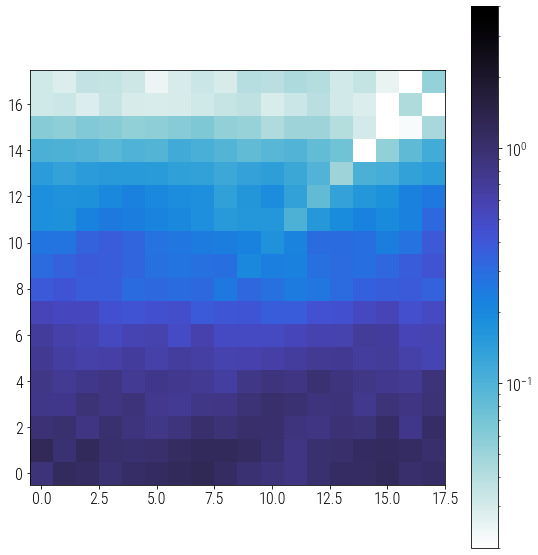

In [754]:
s_ages = calculate_synthetic_ages(new_syn_households)
as_sm = sm.copy()
for a in s_ages:
    as_sm[a, :] = as_sm[a, :]/s_ages[a]
# plt.imshow(as_sm.T, origin='lower', interpolation = 'nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=1e-2, vmax=1e0))
ag_age_by_brackets_dic = sp.get_age_by_brackets_dic(age_brackets)
ag_sages = sp.get_aggregate_ages(s_ages, ag_age_by_brackets_dic)

ag_sm = sp.get_aggregate_matrix(sm, ag_age_by_brackets_dic)
ag_asym = sp.get_asymmetric_matrix(ag_sm, ag_sages)
print(ag_sm.shape)
print(ag_sages)
# print(age_brackets)
# print(ag_age_by_brackets_dic)
# sp.plot_contact_matrix(sm, s_ages, ag_sages, age_brackets, ag_age_by_brackets_dic, 'H', 'density', logcolors_flag=True, aggregate_flag=True)

fign = plt.figure(figsize=(8, 8), tight_layout=True)
axn = fign.add_subplot(111)
imn = axn.imshow(ag_asym.T, origin='lower', interpolation='nearest', cmap='cmr.freeze_r', norm=LogNorm(vmin=2e-2, vmax=4e0))
# div = make_axes_locatable(axn)
# cax = div.new_horizontal(size='5%', pad=0.15)
# cbar = fign.colorbar(imn, cax=cax)
cbar = fign.colorbar(imn)
# cbar.ax.set_ylabel('iho')


Text(0, 0.5, 'Age Count')

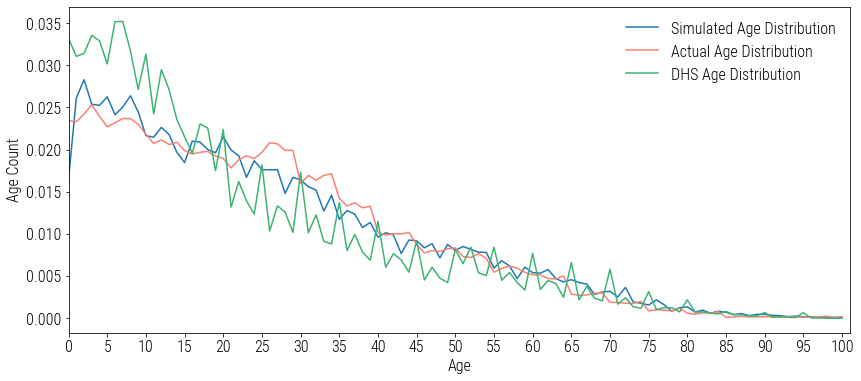

In [755]:
figa= plt.figure(figsize=(14, 6))
axa = figa.add_subplot(111)

norm_s_ages = sp.norm_dic(s_ages)
norm_syn_ages = sp.norm_dic(syn_ages)
norm_ages = sp.norm_dic(ages)

axa.plot(np.arange(101), [norm_s_ages[a] for a in range(101)], color = 'tab:blue', label='Simulated Age Distribution')
axa.plot(np.arange(101), [norm_syn_ages[a] for a in range(101)], color = 'salmon', label='Actual Age Distribution')
axa.plot(np.arange(101), [norm_ages[a] for a in range(101)], color = 'mediumseagreen', label='DHS Age Distribution')
lega = axa.legend(loc=1)
lega.draw_frame(False)
axa.set_xlim(0, 101)
axa.set_xticks(np.arange(0, 101, 5))
axa.set_xlabel('Age')
axa.set_ylabel('Age Count')

In [407]:
sum(s_ages.values())

49785

In [408]:
sum(ages.values())

78931

In [409]:
sum(syn_ages.values())

78931